# Gutenberg Project

In this notebook, we will quantitatively explore the text of the [Gutenberg E-Books Project](https://www.gutenberg.org/), a free repository of e-books that are in the public domain. All of the English and German books have been downloaded for this tutorial and a small python package has been made available that allows you to easily parse the text and the associated metadata. 

<div class="alert alert-success">
<h2>Your goals for this project are to</h2>
<ul>
<li> get a general understanding of the data </li>
<li> create a n-gram viewer to visualize the usage of selected words over time </li>
<li> create a language classifier that can detect languages </li>
</ul>
</div>

The notebook follows a classical data analytics workflow where you load raw data, clean and prepare it, visualize it over and over before you start with the real work of building your analytics tools. 

<div class="alert alert-success">
<h2>This notebook is structured into the following chapters:</h2>
<ol>
<li> <b><a href=#Chapter-1.-System-Setup>System Setup</a> </b></li>
<li> <b><a href=#Chapter-2.-Data-Preparation,-Clean-up,-and-Visualization>Prepare, Clean-Up and Visualize Data</a></b> </li>
<li> <b><a href=#Analyze-Word-Usage-over-Time>Analyzing Evolution of Words over Time</a></b> </li>
<li> <b><a href=#Create-a-Language-Classifier>Create a Language Classifier</a></b> </li>
<li> <b><a href=#Create-Language-Classifier-using-Spark-Pipelines>Create a Languae Classifier using Spark Pipelines</a></b> </li>
</ol>
</div>

Every chapter starts by giving an additional overview its structure. On your way through the notebook you will learn all required Spark concepts to successfully implement the whole workflow. These concepts reflect the standard APIs and helpful techniques for general data analytics workloads. Every chapter we give an overview about the respective learning goals.

<div class="alert alert-success">
<b>Note.</b> To increase reability of such long notebooks me highlight different aspects in different colors.
<ul>
<li> Important information and general notes are highlighted green </li>
<li> Spark and system specific notes are highlighted yellow </li>
<li> Exercises are highlighted blue </li>
</ul>
</div>

## Chapter 1. System Setup
Let us first load a couple of libraries that we will use over and over again.

In [5]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import os, subprocess

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


### Spark configuration

Below we specify that this notebook should use the configuration stored in <code>./spark_config</code> -- the options will be discussed in detail in the next notebook.

<div class="alert alert-warning">
Note that the environment variables have to be declared before any other spark initialization takes place (including creating a <code>SparkConf</code> object.
</div>

In [3]:
ncores = int(os.environ.get('LSB_DJOB_NUMPROC', 1))

os.environ['SPARK_CONF_DIR'] = os.path.abspath('./spark_config')
os.environ['SPARK_DRIVER_MEMORY'] = '%dG'%(ncores*2*0.7)
os.environ['PYSPARK_PYTHON'] = subprocess.check_output('which python', shell=True).rstrip()

import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

## Setting up Python and Spark

Setting up the spark environment can be a bit of a trial and error procedure. Often you'll need to configure settings (in particular dealing with memory) to fit your cluster and your particular application. Below, we will specify a few of the most important ones -- but you can see the full list in the [Spark Configuration guide](http://spark.apache.org/docs/latest/configuration.html) and if you are using YARN there are critical options also listed under the [YARN deployment guide](http://spark.apache.org/docs/latest/running-on-yarn.html).

## Python environment setup

First, we need to make sure that the `pyspark` libraries are accessible in this notebook. To do this, we can add them to the library search path with a convenient `findspark` library: 

In [2]:
import findspark
findspark.init()

<div class="alert alert-danger">
I think we could use this whole part out of the Gutenberg project into the "Introduction to Apache Spark" section of the introductory notebook where we introduce all the low level concepts.
</div>

## Runtime settings

Below we will specify a range of settings for the Spark runtime system. 

<div class="alert alert-warning">
<b>Note.</b>

The environment variables have to be declared before any other spark initialization takes place (including creating a <code>SparkConf</code> object).
</div>

In [3]:
ncores = int(os.environ.get('LSB_DJOB_NUMPROC', 1)) # how many cores do we have for the driver

# here we set the memory we want spark to use for the driver JVM
os.environ['SPARK_DRIVER_MEMORY'] = '%dG'%(ncores*2*0.7)

# we have to tell spark which python executable we are using
os.environ['PYSPARK_PYTHON'] = subprocess.check_output('which python', shell=True).rstrip()

import pyspark
from pyspark import SparkConf, SparkContext

### Initializing `SparkConf` 

When starting the Spark runtime through the notebook or inside a script (i.e. when not calling one of the spark scripts like `spark_submit`), you can create a `SparkConf` object that allows you to set up the runtime. This is quite convenient and much cleaner and more readable than specifying the options on the commandline. 

<div class="alert alert-warning" role="alert" style="margin-top: 10px">
<p><strong>Pro tip</strong></p>

<p>If you use the same base configuration often, you can store it in a file and only override those that are needed through `SparkConf` (we'll do this at the end of this section).</p>
</div>

In [4]:
# initializing the SparkConf
conf = SparkConf()

### Executor options

The full list of options is very long, but the basic ones you'll *always* want to at least think about are ones pertaining to the basic configuration of the executors: 

* number of executors 
* memory per executor
* number of cores per executor

A few notes about the memory configuration: the `spark.executor.memory` should **never** be set to the total memory of the node. Some memory is needed for the OS (including HDFS and other services), and still more is required for the Spark overhead. The amount of memory specified in `spark.executor.memory` is used only for caching of RDDs and temporary shuffle data. This does *not* include memory needed for the python processes and other JVM functions, for example. 

For our case here, this is the basic reasoning: 

* we have 16 Gb of memory per node
* of these, only around 80% (~12 Gb)should be used for the executors 
* leave at least 10% for YARN overhead --> we end up with conservative 9 Gb / executor
* if executors start dying off for unexplained reasons, try reducing the `spark.executor.memory`

In [5]:
conf.set('spark.executor.memory', '9g')

# put the number of executors and cores into variables so we can refer to it later
num_execs = 20
exec_cores = 4

conf.set('spark.executor.instances', str(num_execs))
conf.set('spark.executor.cores', str(exec_cores))

### Memory configuration

Two other key memory options exist, specifying the amount of executor memory reserved for *cached* data and for *shuffle* data. Depending on what your application is doing, you may need more of one or the other. For example, if you are running a lot of iterative operations on a large dataset, you probably want a good amount of memory for RDD caching. On the other hand, if you are doing lots of expensive shuffles that occur when sorting of grouping by key, you may want more shuffle memory. Note that if either one starts to run low, your application (hopefully) won't crash, but instead simply spill to local disk. 

You can check on the cache memory and shuffle memory in two ways while your application is running. In the Spark UI, you can see the cached RDDs under the `Storage` tab - if they start spilling to disk, this is where you will see it. Similarly, if you are running a large shuffle job, you can click on the stage details in the Spark UI and see the shuffle memory and disk statistics. We will check on both of these later on in this application. 

Here we will set these two options explicitly (30% of the heap for caching, 50% for shuffles). Note that the default here is 60% for caching and 20% for shuffles, but we expect to have some fairly memory-hungry shuffles in our application, so we adjust the allocations a bit. 

In [6]:
conf.set('spark.storage.memoryFraction', 0.3)
conf.set('spark.shuffle.memoryFraction', 0.5)

### Driver memory

The amount of memory allocated to the driver program could be crucial if the driver has to deal with a lot of late-stage aggegation products or if you want to collect a significant chunk of data out of the RDD. You can see how much memory has been allocated to the driver either in the Spark Web UI or in the messages printed to the console at initialization. 

In [7]:
conf.set('spark.yarn.am.memory', '8g')
conf.set('spark.yarn.am.cores', 2)

### Reusing a saved configuration

Often, you will probably have a few different jobs that all need the same configuration. Instead of always specifying it inside the notebook, it might be a little cleaner to save it in an external file. 

In this case, we have the configuration saved in `~/spark_workshop/notebooks/gutenberg/spark_config`:

In [8]:
!cat ./spark_config/spark-defaults.conf

# Some default options for Spark 

spark.executor.memory 8g
spark.executor.instances 20
spark.executor.cores 4
spark.storage.memoryFraction 0.5
spark.shuffle.memoryFraction 0.2
spark.yarn.executor.memoryOverhead 2048
spark.yarn.am.memory  8g
spark.yarn.am.cores  4
spark.master yarn
spark.app.name gutenberg

Next time we start the `SparkContext` we can simply set the `SPARK_CONF_DIR` environment variable to point to the directory where our configuration lives, and it will be taken care of automatically. 

<div class="alert alert-warning">
<b>Pro tip.</b>

You can edit the configuration straight from Jupyter by navigating to it directly in the Jupyter file browser.
</div>

### Starting the `SparkContext`

This is our entry point to the Spark runtime - it is used to push data into spark or load RDDs from disk etc. Note that here we specify `master = 'yarn-client'`, which will automatically request the resources we have configured in `conf` above. 

In [10]:
sc = SparkContext(master = 'yarn-client', conf = conf)

HTML(yarn_web_app_string.format(yarn_web_app=yarn_web_app))

### Starting the `SparkContext`
This is our entry point to the Spark runtime - it is used to push data into spark or load RDDs from disk etc. 

In [4]:
sc = SparkContext(master = 'yarn-client')

If this works successfully, you can check the [YARN application scheduler](http://hadoop.ethz.ch:8088/cluster) and you should see your app listed there. Clicking on the "Application Master" link will bring up the familiar Spark Web UI. 

## Chapter 2. Data Preparation, Clean-up, and Visualization

In this chapter you will learn the basics of Spark framework to load and prepare data for further analytics. Our workflow for this chapter is as follows:

<div class="alert alert-success">
<b> Overview </b>
<ol>
<li> Load raw data and parallelize it over the Spark workers </li>
<li> Convert raw data to plain text and metadata</li>
<li> Have an initial look at the data and create a histogram of book lengths </li>
<li> Create a metadata lookup table and distribute it to the workers </li>
<li> Clean the dataset for missing values and repeated entries </li>
</ol>
</div>

we will first load the raw data and parallelize it over the Spark Cluster. Then we will do some simple conversions and clean-up steps. Finally, we create a metadata lookup table that can be distributed to the workers.

<div class="alert alert-success">
<b>The learning goals of this chapter are</b>
<ul>
<li> Loading, querying and transforming data using RDDs </li>
<li> Learn the principals behind the partitioning of RDDs </li>
<li> Converting data to DataFrames </li>
<li> Doing complex queries on DataFrames </li>
<li> Principles of broadcast variables </li>
</ul>
</div>




### 2.1. Load Raw Data and Parallelize it over the Spark Workers

#### Make a key-value RDD of book metadata and text

Getting data into spark from a collection of local files is a very common task. A useful pattern to keep in mind is the following: 

1. make a list of filenames and distribute it among the workers
3. "map" each filename to the data you want to get out
4. now you are left with the RDD of raw data distributed among the workers!

In our case of the Gutenberg Project e-book data, we have a directory of `html` files which hold the actual book text, and another directory of associated metadata files (the RDF files). To make your life easier for the purpose of this tutorial, we have made a small python module called `gutenberg_cleanup` that has some handy functions for pulling out the relevant text and metadata out of the raw dataset. 

The [`gutenberg_cleanup`](gutenberg_cleanup.py) module contains three functions that can help with this: `get_gid`, `get_metadata` and `get_text`.

They pretty much do the obvious: 

`get_gid` takes an html path and pulls out the book ID (`gid`)

`get_metadata` takes a `gid` and returns a metadata object with various useful fields that will be used to create a unique key for each book

`get_text` takes a path to an html file and returns the raw text extracted from HTML, cleaned of tags and punctuation and converted to lower case. 

#### Initializing the raw dataset using `sc.parallelize`

In [5]:
import glob

# get a list of all html files in the data directory
flist = glob.glob('/cluster/work/sdid/roskarr/gutenberg/html/*html')
print('number of books: ', len(flist))

number of books:  48177


When you use `sc.parallelize` to distribute a dataset across the cluster, you can choose the number of partitions across which to distribute the dataset. The higher the number of partitions, the higher the "parallelism". When Spark subsequently executes maps and reduces on this dataset, it does so by dispatching tasks to different executors, which then request the cores under their control to do the actual work. By increasing the number of partitions, you increase the number of tasks - more tasks gives the Spark scheduler more flexibility in distributing the work across the cluster and therefore maximally leveraging the compute resources at its disposal. In some cases, where a single partition might require a lot of memory it can cause `Out of memory` errors - in such cases, simply reducing the amount of data per task by increasing the parallelism can help. 

Note that as long as the tasks take a few hundred milliseconds the scheduler should have no trouble dispatching them. On the other hand, there is a bit of overhead associated with partitioning the data so you don't want an unreasonably high number of partitions. You can see the [Spark guide](http://spark.apache.org/docs/latest/tuning.html#level-of-parallelism) for a bit more detail. 

Below, we will choose to use 5 times as many partitions as we have cores in the job. 

In [6]:
job_conf = dict(sc._conf.getAll())

In [7]:
num_execs = int(job_conf['spark.executor.instances'])
exec_cores = int(job_conf['spark.executor.cores'])

In [8]:
files_rdd = sc.parallelize(flist, num_execs*exec_cores*5)

In [9]:
files_rdd.take(5)

['/cluster/work/sdid/roskarr/gutenberg/html/1000.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10000.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10001.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10002.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10003.html']

#### Transforming the list of filenames into a `key,value` pair RDD of metadata and text

The raw Gutenberg Project dataset consists of HTML files and files that hold metadata in JSON format. For example: 

In [10]:
!head /cluster/work/sdid/roskarr/gutenberg/html/10000.html

In [11]:
!head /cluster/work/sdid/roskarr/gutenberg/rdf-files/10000/pg10000.rdf

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF xml:base="http://www.gutenberg.org/"
  xmlns:cc="http://web.resource.org/cc/"
  xmlns:dcterms="http://purl.org/dc/terms/"
  xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
  xmlns:pgterms="http://www.gutenberg.org/2009/pgterms/"
  xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
  xmlns:dcam="http://purl.org/dc/dcam/"
>
  <pgterms:ebook rdf:about="ebooks/10000">


### 2.2 Convert Raw Data to Plain Book Texts and Metadata

#### Data Ingestion procedure

Our first task is to ingest this dataset by doing the following: 

1. convert the html into raw text
2. deal with special characters, HTML tags, etc.
3. match each metadata entry with its corresponding raw text and compose tuples of the type (metadata, text)


These three steps are often the first step of any analysis, and can be quite time consuming to get right. For the purposes of this exercise, we have already built the functions needed to perform these operations. They are found in [`gutenberg_cleanup.py`](gutenberg_cleanup.py) if you want to have a look. 

The important functions are:

* `get_gid` -- returns the Gutenberg ID given an html file
* `get_text` -- get cleaned, raw text out of an html file
* `get_metadata` -- return the metadata given an ID 

These will be used to construct a `key,value` pair RDD. The `key` will be the dictionary returned by `get_metadata`, while the `value` we will use the raw text returned by `get_text`. 

In [12]:
import gutenberg_cleanup
from gutenberg_cleanup import get_metadata, get_text, get_gid

To pass the `gutenberg_cleanup` source file to the executors, we will use the `addPyFile` method of the `SparkContext`:

In [13]:
sc.addPyFile('{cwd}/gutenberg_cleanup.py'.format(cwd=os.getcwd()))

<div class="alert alert-info">
<b>Exercise.</b> 
Use the `map` method of `files_rdd` to map the filenames to `(metadata, text)` tuples using `get_gid` and `get_text` functions. 
</div>

In [ ]:
id_text_rdd = files_rdd.map(lambda filename: (get_gid(filename), get_text(filename)))

<div class="alert alert-info">
<b>Exercise.</b> 
Now we have (ID, text), and we need to make another `map` to get (`metadata, text`) tuples.
</div>

In [15]:
text_rdd = (id_text_rdd.map(lambda (ID, text): (get_metadata(ID), text)))

So that we don't have to constantly re-load the data off disk, lets cache this RDD: 

In [16]:
%%time
text_rdd.cache()
text_rdd.count()

CPU times: user 86 ms, sys: 19 ms, total: 105 ms
Wall time: 2min 26s


Since we called `count()`, it means that the entire RDD was generated/calculated. This combination of `cache` and `count` is a common way to check how much memory your dataset needs - once `count` completes you can check the memory taken up by the RDD by going to the "Storage" tag of the Spark UI. 

Because the data is cached, next time you try to use `text_rdd` it will be much much quicker. For example, 

In [17]:
%%time
assert(text_rdd.count() == 48177)

CPU times: user 47 ms, sys: 10 ms, total: 57 ms
Wall time: 3.09 s


As an aside, we could call the native python `map` in exactly the same way (and run it on the local machine only), though this would take much longer to complete, i.e. 

    text = map(lambda f: (get_metadata(get_gid(f)), get_text(f)), flist)

<div class="alert alert-danger">
I am not sure whether we should keep this. I think we just should make sure that students can load the data required for every chapter at the beginning of the chapter in case they have failed to get to this point.
</div>

### 2.3 Save the raw dataset to HDFS (or local storage)

As a final bit of preparation before continuing with analysis, we save the raw data in a way that makes it faster to access later. We don't want to have to read the data off local disk every time we need to repeat some part of the analysis. Instead, it's much more advantageous to use the Hadoop Distributed File System (HDFS) to store the data once we've read it in and put it in a `key,value` format. 

By storing the data in HDFS, we make sure that the system can take advantage of data-locality at a later stage in our analysis. 

In [18]:
!hadoop fs -rm -r -f /user/roskarr/gutenberg/raw_text_rdd

Picked up _JAVA_OPTIONS: -XX:ParallelGCThreads=1
15/11/20 15:00:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/11/20 15:00:59 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/roskarr/gutenberg/raw_text_rdd


In [19]:
text_rdd.saveAsPickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

Now, whenever we need it, we can read the data off the HDFS instead: 

In [20]:
text_rdd = sc.pickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

In [21]:
%time text_rdd.count()

CPU times: user 48 ms, sys: 9 ms, total: 57 ms
Wall time: 6.17 s


48177

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import subprocess

from IPython.display import HTML
import xml.etree.ElementTree as ET
try:
    tree = ET.parse(os.environ['HADOOP_CONF_DIR'] + '/yarn-site.xml')
except IOError:
    raise IOError("Can't find the yarn configuration -- is HADOOP_CONF_DIR set?")
root = tree.getroot()
yarn_web_app = root.findall("./property[name='yarn.resourcemanager.webapp.address']")[0].find('value').text
yarn_web_app_string = "If this works successfully, you can check the <a target='_blank' href='http://{yarn_web_app}'>YARN application scheduler</a> and you should see your app listed there. Clicking on the 'Application Master' link will bring up the familiar Spark Web UI. "

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

<div class="alert alert-danger"> delete </div>
### Preprocessing procedure

#### In this notebook, we will pre-process the text corpus using Spark

The basic steps will be something like:

2. create a metadata lookup table that can be distributed to the workers
3. clean the dataset for missing values and repeated entries
4. save the final, cleaned dataset to HDFS

But first, we need to set up the Spark runtime.

<div class="alert alert-danger"> maybe delete </div>
### Loading the dataset from HDFS

I have already pre-loaded the data for you to avoid some tedious boilerplate code. If you want to see the process anyway, you can have a look at the [data input notebook](part0-data-input.ipynb).

Here, we just load the data from my HDFS:

In [11]:
text_rdd = sc.pickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

In [12]:
%time text_rdd.cache().count()

CPU times: user 44 ms, sys: 19 ms, total: 63 ms
Wall time: 31.1 s


48177

This operation loaded the data from the Hadoop distributed filesystem and created an RDD. If you look at the details for this stage in the Spark UI (click on the "Stages" tab at the top, then click on the "count" stage at the top of the list) you can understand why this is: in the column named "locality level", you see that for many tasks it says `NODE LOCAL` while for others it might say `RACK LOCAL`. These mean that either the data chunk was physically present on the disk of the node that was reading it in (`NODE LOCAL`) or it was on one of the nodes on the same switch (`RACK LOCAL`). Of course the additional advantage is not having to deal with the filesystem overhead of 10k+ small files. 

You can also check how much memory this raw data occupies by clicking on the "Storage" tab in the Spark UI. Note that if the value reported there says the data is serialized, it means it's also likely compressed so the actual size is a bit larger. 

Before we continue, have a look at the [Transformations](http://spark.apache.org/docs/latest/programming-guide.html#transformations) and [Actions](http://spark.apache.org/docs/latest/programming-guide.html#actions) in the Spark programming guide or the list of [RDD methods in the Spark API](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) to refresh your memory about what is available to you.

### 2.3. A first look at the data: creating a histogram of book lengths

Lets have a look at what the RDD looks like

<div class="alert alert-info">
<b>Exercise.</b>
Use the `first` method of the RDD to retrieve data.
</div>

In [13]:
meta, text = text_rdd.first()
print('metadata: ', meta)
print('\ntext: ', text[20000:21000])

metadata:  {'lang': u'en', 'first_name': None, 'last_name': None, 'title': '- No Title -', 'downloads': u'243', 'death_year': None, 'gid': 1000, 'birth_year': None}

text:  di qua nuova schiera sauna ltltquelli che muoion ne lira di dio tutti convegnon qui dogne paese che la divina giustizia li sprona si che la tema si volve in disio e pero se caron di te si lagna ben puoi sapere omai che l suo dir suonagtgt tremo si forte che de lo spavento la mente di sudore ancor mi bagna che baleno una luce vermiglia la qual mi vinse ciascun sentimento un greve truono si chio mi riscossi come persona che per forza desta dritto levato e fiso riguardai per conoscer lo loco dovio fossi de la valle dabisso dolorosa che ntrono accoglie dinfiniti guai tanto che per ficcar lo viso a fondo io non vi discernea alcuna cosa comincio il poeta tutto smorto ltltio saro primo e tu sarai secondogtgt dissi ltltcome verro se tu paventi che suoli al mio dubbiare esser confortogtgt che son qua giu nel viso mi dipigne 

For each data element we have a tuple containing a dictionary of metadata (`'lang'`, `'first_name'` etc.), and the text.

#### How long are the documents? 

Lets have a quick look at the number of words in these books. We'll do this by taking the values (text) of the `text_rdd` (there is a `values()` method that discards the keys of the RDD), use the `split` method of the text string to break it up into a list of words, and then use the built-in `len` method to get the length of this sequence. Finally, we will use the `collect` method to extract the numbers to the driver. 

<div class="alert alert-info">
<b>Exercise.</b>
Map text_rdd to contain only the number of words in each document.
</div>

In [14]:
text_lengths = (text_rdd.values()
                        .map(lambda text: len(text.split()))).collect()

In [15]:
assert(text_lengths[:10] == [66976, 17180, 8455, 53847, 65001, 50678, 72798, 16398, 30705, 68609])

We can quickly plot a histogram:

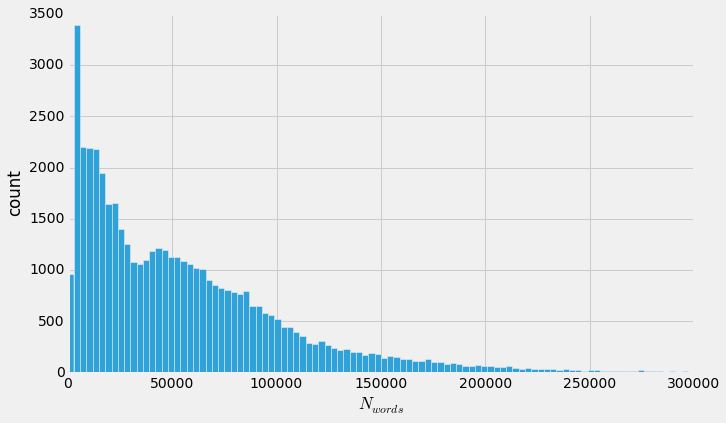

In [16]:
plt.hist(text_lengths, bins = 100, range=[0,3e5]);
plt.xlabel('$N_{words}$'); plt.ylabel('count');

### 2.4 Create a Metadata Lookup Table and Distribute it to the Workers
#### Broadcast variables: a good way to distribute metadata

Note that our dataset at the moment is composed of `(dictionary, text)` tuples. This is not ideal for several reasons: first, complex structures like dictionaries are more expensive to serialize, so replacing them by simple integer IDs can improve performance. And second, dictionaries are not hashable so cannot serve as keys. 

The solution is to replace the dictionary with just a single ID integer (in this case we already have it, the `gid` or the gutenberg ID of the book). However, as we manipulate the dataset, we will still want ready access to the metadata, but at the moment we have no efficient way of working with it. What we want is to generate a lookup table of metadata that can easily be retrieved when needed. 

For these kinds of situations when passing around some data to all the workers is required, you should use Spark's [broadcast variable](http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables) mechanism. By placing data inside a broadcast variable, you make it available to all the workers and it only needs to be sent across the network once. The next time a value from the broadcast variable is needed, it's simply taken from the local executor's memory, incurring no extra network cost. 

In [17]:
# set up the list of fields
metadata_fields = text_rdd.first()[0].keys() # this takes the metadata of the first element and extracts the keys
meta_dict = dict()

for meta in text_rdd.keys().collect() :
    meta_dict[meta['gid']] = {key: meta[key] for key in metadata_fields}

This is now a look-up table that allows us to quickly access all the metadata indexed by `gid`. For example to get the metadata of book with `gid=101`:

In [18]:
meta_dict[101]

{'birth_year': u'1954',
 'death_year': None,
 'downloads': u'352',
 'first_name': u'Bruce',
 'gid': 101,
 'lang': u'en',
 'last_name': u'Sterling',
 'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

To get, for example, the author birth year for book with `gid = 101`:

In [19]:
meta_dict[101]['birth_year']

u'1954'

Now we need to create the broadcast variable: 

In [20]:
# call it meta_b for 'broadcast'
meta_b = sc.broadcast(meta_dict)

The underlying data object stored in `meta_b` can be accessed simply by

    > meta_b.value
    
We'll make use of this soon. If you check the console output, you will see an INFO message that the broadcast has been created, i.e. 

```
15/06/24 17:18:44 INFO storage.MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 910.7 KB, free 4.1 GB)
15/06/24 17:18:44 INFO storage.BlockManagerInfo: Added broadcast_6_piece0 in memory on 10.201.20.22:47821 (size: 910.7 KB, free: 4.1 GB)
15/06/24 17:18:44 INFO spark.SparkContext: Created broadcast 6 from broadcast at PythonRDD.scala:403
```

#### Save the metadata dictionary for later use
We will need the metadata dictionary at a later point, so we save it to disk now to avoid having to regenerate it later. 

In [21]:
from cPickle import dump

In [22]:
dump(meta_dict, open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'w'))

### 2.5. Clean the Dataset for Missing Values and Repeated Entries

Now we're ready to do some quality checks on the data. Let's check out the first couple of metadata entries: 

In [23]:
text_rdd.keys().take(2)

[{'birth_year': None,
  'death_year': None,
  'downloads': u'243',
  'first_name': None,
  'gid': 1000,
  'lang': u'en',
  'last_name': None,
  'title': '- No Title -'},
 {'birth_year': None,
  'death_year': None,
  'downloads': u'269',
  'first_name': None,
  'gid': 10000,
  'lang': u'en',
  'last_name': u'Anonymous',
  'title': u'The Magna Carta'},
 {'birth_year': u'1863',
  'death_year': u'1950',
  'downloads': u'274',
  'first_name': u'Lucius Annaeus',
  'gid': 10001,
  'lang': u'en',
  'last_name': u'Seneca',
  'title': u'Apocolocyntosis'},
 {'birth_year': u'1877',
  'death_year': u'1918',
  'downloads': u'865',
  'first_name': u'William Hope',
  'gid': 10002,
  'lang': u'en',
  'last_name': u'Hodgson',
  'title': u'The House on the Borderland'},
 {'birth_year': u'1833',
  'death_year': u'1923',
  'downloads': u'15',
  'first_name': u'Mary King',
  'gid': 10003,
  'lang': u'en',
  'last_name': u'Waddington',
  'title': u'My First Years as a Frenchwoman, 1876-1879'}]

If you look at just the first few entries it becomes clear that we're going to have to do some quality control here. For example, we probably don't want books with "None" as either of the author names, and likewise we have to have the birth date in order to be able to create a time series out of the data in the end. 

Construct an RDD, as above, except that you filter out all the elements that have `None` for `title`, `first_name`, `last_name`, or `birth_year`. In addition, filter out the data with "BC" in either birth or death year. 

As a reminder, here is a cartoon illustration of the difference between `map` and `filter` RDD methods. `map` simply applies the function to each element, returning another element. 

![map](../figs/map_example.svg)

In this example, with `filter` we are filtering out all the even elements of the RDD. The function that is passed to `filter` just has to evaluate to either `True` (1) or `False` (0) given the input data. The function `lambda (k,v): v%2` evaluates to 0 if `v` is even and 1 of `v` is odd. Hence, only the odd values pass the filter. 

![filter](../figs/filter_example.svg)

The `filter_func` has already been defined for you below, but you need to apply it to `text_rdd`. 

In [24]:
def filter_func(meta) : 
    no_none = all([meta[name] is not None for name in ['title', 'first_name', 'last_name', 'birth_year']])
    if not no_none : 
        return False
    else : 
        no_birth_bc = 'BC' not in meta['birth_year']
        no_death_bc = True if meta['death_year'] is None else 'BC' not in meta['death_year']
        return no_birth_bc & no_death_bc

In [25]:
# TODO
filtered_rdd = text_rdd.filter(lambda (meta, text): filter_func(meta))

In [26]:
filtered_rdd.keys().take(5)

[{'birth_year': u'1863',
  'death_year': u'1950',
  'downloads': u'274',
  'first_name': u'Lucius Annaeus',
  'gid': 10001,
  'lang': u'en',
  'last_name': u'Seneca',
  'title': u'Apocolocyntosis'},
 {'birth_year': u'1877',
  'death_year': u'1918',
  'downloads': u'865',
  'first_name': u'William Hope',
  'gid': 10002,
  'lang': u'en',
  'last_name': u'Hodgson',
  'title': u'The House on the Borderland'},
 {'birth_year': u'1833',
  'death_year': u'1923',
  'downloads': u'15',
  'first_name': u'Mary King',
  'gid': 10003,
  'lang': u'en',
  'last_name': u'Waddington',
  'title': u'My First Years as a Frenchwoman, 1876-1879'},
 {'birth_year': u'1864',
  'death_year': u'1948',
  'downloads': u'9',
  'first_name': u'Anna Robertson Brown',
  'gid': 10004,
  'lang': u'en',
  'last_name': u'Lindsay',
  'title': u'The Warriors'},
 {'birth_year': u'1775',
  'death_year': u'1861',
  'downloads': u'17',
  'first_name': u'George',
  'gid': 10005,
  'lang': u'en',
  'last_name': u'Tucker',
  'title

How many do we have left? 

In [27]:
nfiltered = filtered_rdd.count()
print('number of books after filtering: ', nfiltered)
assert(nfiltered == 34123)

number of books after filtering:  34123


#### A final bit of cleanup: 

some of the books end up split across multiple entries. Since it's the same book, each of the entries should have the same `gid`. 

To check for this we will use one of the most basic and common MapReduce patterns -- the key count: 

* map the data into `key`,`value` pairs where `key` is the quantity we want to count and `value` is just 1. In this case, the `key` will be `gid`
* invoke a reduction *by key*, where the reduction operator is a simple addition

Finally, we will sort the result in descending order and print out the first few elements to check whether we have to worry about documents spanning multiple files or not. 

The RDD operations that are needed are [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) and [sortBy](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.sortBy).

`reduceByKey` works by grouping all data of a key together and applying the reduction function just to that data. Here's a simple illustration, in this case using a simple addition of two elements as a reduction:

![reducebykey](../../slides/figs/reduceByKey_example.svg)



For the `keyFunc` of the call to `sortBy`, use a `lambda` function that extracts the counts obtained from the `reduceByKey`. 

So, the procedure should be : 

1. `map` the `filtered_rdd` using a lambda function to contain (`gid`, 1) tuples
2. `reduceByKey`
3. `sortBy` (specify decreasing order, see the API) 

In [28]:
from operator import add

In [29]:
# TODO: map the filtered_rdd to contain just the tuple (gid, 1)
map_filtered = filtered_rdd.map(lambda (meta, text): (meta['gid'],1))

# reduce the map_filtered rdd by key to get the total counts per gid
reduced_gid_rdd = map_filtered.reduceByKey(add)

# sort by count and print out the top 10
reduced_gid_rdd.sortBy(lambda (key, count): count, False).take(10)

[(30310, 51),
 (6478, 43),
 (3772, 40),
 (8700, 35),
 (3332, 33),
 (12233, 29),
 (27672, 23),
 (3425, 23),
 (20776, 18),
 (2440, 16)]

In [30]:
assert(_ == [(30310, 51), (6478, 43), (3772, 40), (8700, 35), (3332, 33), (12233, 29), (3425, 23), (27672, 23), (20776, 18), (2440, 16)])

AssertionError: 

Note that there are several transformations here that lead to the final result, `sorted_reduced`. A common syntax is to group them all together, by enclosing them in `( )` and chaining them: 

In [ ]:
# TODO: repeat the above steps but chain them together
(filtered_rdd.map(lambda (meta, text): (meta['gid'], 1))
             .reduceByKey(add)
             .sortBy(lambda (key,count): count, False)
             .take(10))

Looks like we have a few that are made up of multiple sections. To combine them, we will use `reduceByKey` which will result in having an RDD of `gid`'s as keys and the combined text of each `gid`. The reduction function in `reduceByKey` can be a simple in-line function that just adds two elements together -- in this case we just use the `add` operator.

In [32]:
cleaned_rdd = (filtered_rdd.map(lambda (meta, text): (meta['gid'], text))
                           .reduceByKey(add))

As a simple sanity check, lets look at `gid`=6478, which according to the cell above has 43 sections in the original dataset: 

In [34]:
len(filtered_rdd.map(lambda (meta, text): (meta['gid'],1))
                .lookup(6478))

43

In [35]:
len(cleaned_rdd.lookup(6478))

1

To avoid having to do all these pre-processing steps again at a later point, lets also save the `cleaned_rdd`:

In [39]:
cleaned_rdd.saveAsPickleFile('/user/{username}/gutenberg/cleaned_rdd'.format(username=os.environ['USER']))

This is now saved in the directory we specified, one file per partition:

In [40]:
!hadoop fs -ls /user/$USER/gutenberg/cleaned_rdd | head

Picked up _JAVA_OPTIONS: -XX:ParallelGCThreads=1
15/11/20 16:22:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 401 items
-rw-r--r--   3 roskarr supergroup          0 2015-11-20 16:22 /user/roskarr/gutenberg/cleaned_rdd/_SUCCESS
-rw-r--r--   3 roskarr supergroup   81072401 2015-11-20 16:21 /user/roskarr/gutenberg/cleaned_rdd/part-00000
-rw-r--r--   3 roskarr supergroup   33277657 2015-11-20 16:21 /user/roskarr/gutenberg/cleaned_rdd/part-00001
-rw-r--r--   3 roskarr supergroup   24855133 2015-11-20 16:21 /user/roskarr/gutenberg/cleaned_rdd/part-00002
-rw-r--r--   3 roskarr supergroup   26256221 2015-11-20 16:21 /user/roskarr/gutenberg/cleaned_rdd/part-00003
-rw-r--r--   3 roskarr supergroup   32900633 2015-11-20 16:21 /user/roskarr/gutenberg/cleaned_rdd/part-00004
-rw-r--r--   3 roskarr supergroup   27338328 2015-11-20 16:21 /user/roskarr/gutenberg/cleaned_rdd/part-00005
-rw-r--r--   3 roskarr sup

In [41]:
!hadoop fs -du -h /user/$USER/gutenberg/

Picked up _JAVA_OPTIONS: -XX:ParallelGCThreads=1
15/11/20 16:22:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
10.8 G  /user/roskarr/gutenberg/cleaned_rdd
14.6 G  /user/roskarr/gutenberg/raw_text_rdd


Note that here we used the `hadoop` command in the local bash shell (the `!` at the beginning of the line means we are executing the command in the shell). This allows us to access the hadoop filesystem (HDFS), which is separate from the local file system we are used to. You'll notice, for example, that this directory doesn't exist in the local filesystem:

In [42]:
!ls /user/$USER/gutenberg/

ls: cannot access /user/roskarr/gutenberg/: No such file or directory


You can also browse the filesystem via the [HDFS web UI](http://hadoop.ethz.ch:50070). The `hadoop fs` command has many of the same options as regular Linux/Unix shell commands you might be used to for manipulating files and directories. Try running

```bash
cluster $> module load hadoop
cluster $> hadoop fs -help
```

in a new shell to see all the options. 

#### Recap of steps up until this point

We've done quite a lot already with our dataset in Spark, although it's only the beginning!

1. created an RDD of filenames (`filename_rdd`)
2. transformed the `filename_rdd` into an RDD of `(metadata, text)` (`text_rdd`); we also saved this to HDFS
3. filtered out data with bad metadata, e.g. missing author names etc.
3. cleaned up the entries a bit more by merging ones with identical IDs; we called this `cleaned_rdd`

#### Shutting down the `SparkContext`

Now that the pre-processing is done, we will shut down the `SparkContext` before continuing to the data analysis notebook. We have all of our results saved in HDFS, so to continue from where we left off will just require loading data from there. 

In [43]:
sc.stop()

Now that the pre-processing steps are complete, we can continue to the [analysis notebook](part2-ngram-viewer-SOLUTIONS.ipynb)

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import subprocess

from IPython.display import HTML
import xml.etree.ElementTree as ET
try:
    tree = ET.parse(os.environ['HADOOP_CONF_DIR'] + '/yarn-site.xml')
except IOError:
    raise IOError("Can't find the yarn configuration -- is HADOOP_CONF_DIR set?")
root = tree.getroot()
yarn_web_app = root.findall("./property[name='yarn.resourcemanager.webapp.address']")[0].find('value').text
yarn_web_app_string = "If this works successfully, you can check the <a target='_blank' href='http://{yarn_web_app}'>YARN application scheduler</a> and you should see your app listed there. Clicking on the 'Application Master' link will bring up the familiar Spark Web UI. "

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

<div class="alert alert-danger">
<h1>Analyze Word Usage over Time</h1>
</div>

<div class="alert alert-success">
<b>The learning goals of this chapter are</b>
<ul>
<li> Learn about reduce, shuffles, partitioning and implications on network load </li>
<li> Reduce network load with mapPartition </li>
<li> Learn word vectorization methods using n-grams </li>
<li> Learn to use treeAggregate </li>
</ul>
</div>


# Analyzing the Gutenberg Books Corpus

In this notebook, we will use the cleaned, pre-processed data that we created in the [pre-processing part](gutenberg-preprocessing-SOLUTIONS.ipynb). As a reminder, we ended up with an RDD of `(gid, text)` tuples that has been cleaned and we stored it on HDFS at `/user/<YOUR_USERNAME>/gutenberg/cleaned_rdd`. 

We have two goals in this notebook:

1. generate data that will enable us to create something like the [Google Ngram Viewer](https://books.google.com/ngrams) but for the Gutenberg book corpus. 
2. Use Spark's machine learning library to perform language classification on the English and German book corpus

## Set up and launch the Spark runtime

Remember from the previous notebook that we have a saved configuration in `./spark_config/` -- so all we need to do is set the `SPARK_CONF_DIR` environment variable and our default configuration will be used: 

In [2]:
os.environ['SPARK_CONF_DIR'] = os.path.realpath('./spark_config')

As before, we'll also set the amount of memory we want to use for the driver and set up the paths using `findspark`:

In [3]:
# how many cores do we have for the driver
ncores = int(os.environ.get('LSB_DJOB_NUMPROC', 1)) 

# here we set the memory we want spark to use for the driver JVM
os.environ['SPARK_DRIVER_MEMORY'] = '%dG'%(ncores*2*0.7)

# we have to tell spark which python executable we are using
os.environ['PYSPARK_PYTHON'] = subprocess.check_output('which python', shell=True).rstrip()

import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

Note that there is another file in `./spark_config`: 

In [4]:
!cat ./spark_config/log4j.properties

# Set everything to be logged to the console
log4j.rootCategory=WARN, console
log4j.appender.console=org.apache.log4j.ConsoleAppender
log4j.appender.console.target=System.err
log4j.appender.console.layout=org.apache.log4j.PatternLayout
log4j.appender.console.layout.ConversionPattern=%d{yy/MM/dd HH:mm:ss} %p %c{1}: %m%n
log4j.appender.file_appender.File=${spark.yarn.app.container.log.dir}/spark.log

# Settings to quiet third party logs that are too verbose
log4j.logger.org.eclipse.jetty=WARN
log4j.logger.org.eclipse.jetty.util.component.AbstractLifeCycle=ERROR
log4j.logger.org.apache.spark.repl.SparkIMain$exprTyper=INFO
log4j.logger.org.apache.spark.repl.SparkILoop$SparkILoopInterpreter=INFO

# get all info from the mllib components
log4j.logger.org.apache.spark.mllib=INFO, console
log4j.additivity.org.apache.spark.mllib=false

# make sure we get warnings from scheduler and storage
log4j.logger.org.apache.spark.scheduler=WARN, console
log4j.additivity.spark.scheduler=false
log4j.logger.

This logging set-up quiets down the amount of stuff we see in the console...

### Initializing the `SparkContext`

We'll create an empty `SparkConf` here for completeness -- if we needed to, we could alter any of the settings here. Then we launch the `SparkContext` as before:  

In [5]:
conf = SparkConf()

In [6]:
conf.set('spark.metrics.conf', '/cluster/home03/sdid/roskarr/spark_graphite_conf/metrics.properties')

In [7]:
sc = SparkContext(master='yarn-client', conf=conf)

## Load the data from HDFS

In [8]:
# TODO: load cleaned_rdd from your directory HDFS
cleaned_rdd = sc.pickleFile('/user/roskarr/gutenberg/cleaned_rdd').setName('cleaned_rdd').cache()

A quick inspection of the data to remind ourselves what it looks like: 

In [8]:
gid, text = cleaned_rdd.first()
print(gid, text[10000:10500]) # somewhere in the middle of the book

12800  conceive what might have happened if it had been some other of our presidents who had happened to have his term begin in yet after all the study that can be made of him there are unexplainable elements in lincolns character which will leave him forever an enigma if the world ever settles down to the acceptance of any definite accurate picture of him it will surely be a false picture there must always be vague indefinable uncertainties in any presentation of him which shall be truly made of the 


In [9]:
cleaned_rdd.count()

33666

### Load in the metadata dictionary and broadcast it

In [10]:
from cPickle import load

with open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'r') as f :
    meta_dict = load(f)

In [11]:
# TODO: create meta_b by broadcasting meta_dict
meta_b = sc.broadcast(meta_dict)

Now, our `cleaned_rdd` contains `gid`'s as keys and text as values and if we want some other piece of metadata, we can just access it via the lookup table, for example `meta_b.value[gid][meta_name]`. 

### Histogram of book publication years
Now we're ready to start asking some questions of the data. To begin with, lets do a simple histogram of the year distribution of the books. Since we don't have original publication dates, we just use the simple formula: 

$year = max\left((year_{birth} + year_{death})/2, year_{birth} + offset\right)$, 

where $offset$ is a number drawn from a gaussian centered on 40 with $\sigma = 5$ years. This means that we assume most people write their books around age 40. ;)

The function `publication_year` is provided for you and you should use it to *transform* the `year_rdd` into an RDD of publication years. 

Remember that we created a broadcast variable at the beginning of the notebook, which can be used to efficiently look up metadata.

In [19]:
from random import gauss

def publication_year(gid) : 
    """Returns the publication year for the given gutenberg id (gid)"""
    
    # extract the metadata dictionary for this gid
    meta = meta_b.value[gid]
    
    birth_year = int(meta['birth_year'])
    if meta['death_year'] is None : 
        year = birth_year + np.random.normal(40,5)
    else :
        death_year = int(meta['death_year'])
        year = max((birth_year + death_year) / 2.0, birth_year+gauss(40,5))

    return min(int(year),2015)

In [24]:
# TODO: map cleaned_rdd to contain just the publication years by using the publication_year function above
year_rdd = cleaned_rdd.map(lambda (gid, text): publication_year(gid))
                       
year_rdd.count()

33666

In [25]:
year_rdd.first()

1888

The histogram function actually already exists in the Spark API (but it didn't use to!). However, for fun we will write our own. Calculating the histogram can be split up into two parts:

2. calculate the bin that the value maps to and create an RDD of (`bin`, 1) pair
3. do a `reduceByKey` where we just add up all the values belonging to each bin. 

The last step is the simplest for us to execute, but the most complicated in terms of what happens behind the scenes. The reduction happens in two parts - first, it creates a list of `(key, count)` pairs locally by iterating through all the elements of the partition and creating a hash table. Then, these pairs are communicated to other partitions and added up. 

In [31]:
# define a helper function to determine which bin a value falls into
from bisect import bisect_right
def get_bin(bin_edges, value) : 
    """Returns which bin, specified by `bin_edges`, the `value` falls into."""
    
    return bisect_right(bin_edges, value) - 1

In [32]:
# TODO: fill in the bits and pieces of the histogram function

def histogram(rdd, nbins = 100, min_val=None, max_val=None) :
    """
    Calculate a histogram of the data, given the number of bins and the data range. 
    
    Arguments: 
        
        rdd: the data RDD
    
    Optional Keywords:
        
        nbins: number of bins (default 100)
        
        min_val: minimum value to consider (default, min value of the input data)
        
        max_val: maximum value to consider (default, max value of the input data)
    
    Returns: 
        
        tuple of bins and array of counts
        
    """
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min() # FILL IN --> look at the Spark API!
    if max_val is None : 
        max_val = rdd.max() # FILL IN --> look at the Spark API!
        
    # create the array of bin edges
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    # create an RDD where each data value is mapped into a tuple (bin, 1) that will 
    # be used for counting up the bin values (use the get_bin function defined above to generate the bin)
    binned_rdd = rdd.map(lambda x: (get_bin(bin_edges, x),1)) # FILL IN 
    
    # reduce binned_rdd 
    summed_bins = binned_rdd.reduceByKey(lambda a,b:a+b).collect() # FILL IN 
    
    # This is a sparse result -- turn into a dense vector for plotting: 
    res_full = np.zeros(nbins)
    overflow = 0
    for item in summed_bins : 
        if item[0] > len(res_full)-1 or item[0] < 0: 
            continue # ignore
        else: res_full[item[0]] = item[1]
            
    return .5*(bin_edges[:-1]+bin_edges[1:]), res_full

In [33]:
%time bins, vals = histogram(year_rdd, min_val=1500, max_val=2015)

CPU times: user 170 ms, sys: 49 ms, total: 219 ms
Wall time: 5.52 s


Finally, here is the histogram of publication years:

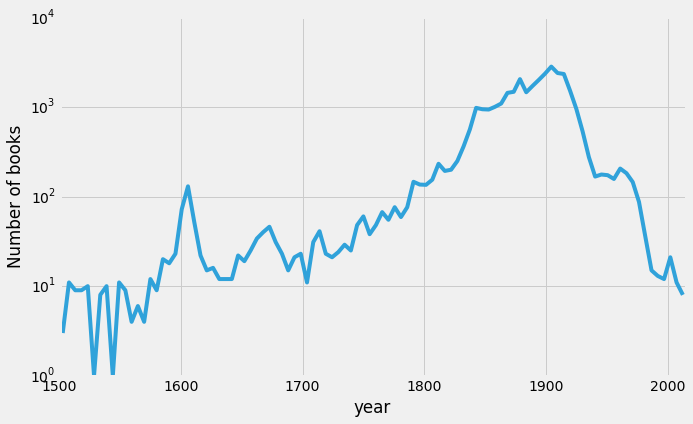

In [34]:
plt.plot(bins, vals)
plt.xlim(1500,2015)
plt.xlabel('year')
plt.ylabel('Number of books')
plt.semilogy();

### Reducing network traffic by using `mapPartition`

This kind of operation is a good candidate for first computing a partial result on each partition and then following with a reduce step. 

In our `histogram` function above, the `reduceByKey` step requires a reshuffling of the data which means spending potentially a lot of time in network communication and other overhead associated with creating distributed hash tables for all the keys. 

However, since our binning function effectively already hashes the values anyway, we can avoid this by instructing first each partition to calculate its local histogram and then simply adding up the histograms in the end. In this way, we are basically combinging the `map` operation with a local `reduce` operation, and since the number of bins is always relatively small, we end up sending a trivial amount of data across the network. 

Here is where our knowledge of generators comes in handy, because the method [`mapPartitions`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mapPartitions) *requires* a generator function. 

The key here is to define a histogram function that calculates the histogram on each partition locally. `mapPartitions` gives us an *iterator* over the data; we need to extract the data out of this iterator and calculate the local histograms *for the data in each partition*. Below, this is accomplished using the `bin_partition` function.

Finally, we define a new `histogram_partition` function that uses `bin_partition` to compute the local histograms and a simple addition in a `reduce` operation to sum up the histograms in the end. 

In [35]:
def bin_partition(iterator, nbins,  min_val, max_val) : 
    """
    Perform the binning of data contained in an iterator
    
    Arguments: 
        
        iterator: the data iterable 
        
        nbins: number of bins
        
        min_val, max_val: min and max values to consider
    
    yields the local histogram
    """
    from bisect import bisect_right
    
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    histogram = np.zeros(len(bin_edges)-1)
    
    for item in iterator : # iterating over all the items in the partition
        try : 
            ind = get_bin(bin_edges,item)
            histogram[ind] += 1
        except IndexError : 
            pass
        
    yield histogram

def histogram_partition(rdd, nbins = 100, min_val=None, max_val=None) :
    """
    Calculate a histogram of the data by using partition methods
    
    Arguments: 
    
        rdd: the data
        
    Optional Keywords:
    
        nbins: number of bins (default 100)
        
        min_val: minimum value to consider (default, min value of the input data)
        
        max_val: maximum value to consider (default, max value of the input data)
    
    Returns: 
        
        tuple of bins and array of counts
    """
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min() # FILL IN
    if max_val is None : 
        max_val = rdd.max() # FILL IN
        
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    result = (rdd.mapPartitions(lambda iterator: bin_partition(iterator, nbins, min_val, max_val))
                 .reduce(lambda a,b: a+b))
    
    return .5*(bin_edges[:-1]+bin_edges[1:]), result

In [36]:
%time bins, vals = histogram_partition(year_rdd, min_val=1500, max_val=2015)

CPU times: user 89 ms, sys: 6 ms, total: 95 ms
Wall time: 3.75 s


The difference here doesn't look dramatic because the total amount of data is rather small, but have a look at the Spark Web UI and you will see that the second implementation didn't do any shuffle writing. If you have a large number of keys, the intermediate shuffles that need to take place can have a substantial impact on performance. With a bigger data set, this difference could potentially matter quite a lot!

### Inspecting the metadata some more

Lets do a couple more checks and practice using the Spark API. 

#### How many unique authors are there in the dataset? 

1. make `author_rdd` that is composed of a string `"last_name, first_name"` (use the broadcast variable `meta_b` to get the data for each `gid`)
2. keep only the unique author strings (*hint*: look at the Spark API to find an appropriate method)
3. count the number of elements remaining

**note**: use `meta_b.value` to access the actual metadata dictionary, for example, to get the metadata for `gid=101`:

In [38]:
meta_b.value[101]

{'birth_year': u'1954',
 'death_year': None,
 'downloads': u'352',
 'first_name': u'Bruce',
 'gid': 101,
 'lang': u'en',
 'last_name': u'Sterling',
 'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

In [39]:
# TODO: map cleaned_rdd to contain the string "last_name, first_name" 
author_rdd = cleaned_rdd.map(lambda (gid, text): 
                             "%s %s"%(meta_b.value[gid]['last_name'], meta_b.value[gid]['first_name']))

In [40]:
# TODO: use RDD methods to obtain the distinct author strings and count them
n_authors = (author_rdd.distinct()
                       .count())
print("Number of distinct authors: %s " % n_authors)

Number of distinct authors: 10192 


In [41]:
assert(n_authors == 10192)

#### Most-represented authors in the corpus: 

1. use the `author_rdd` from above
2. use the pattern `(key, 1)` to set up an RDD that can be passed to `reduceByKey`
3. run `reduceByKey`, yielding an RDD composed of `(author, count)` tuples
4. sort by descending order of number of books per author and print out the top 10 (try using `takeOrdered`)

In [42]:
# TODO: generate a list of authors, reverse-sorted by the number of books they have in the corpus
(author_rdd.map(lambda author: (author, 1))
           .reduceByKey(lambda a,b: a+b)
           .takeOrdered(10, lambda (a,c): -1*c))

[(u'Shakespeare William', 295),
 (u'Lytton Baron Lytton', 218),
 (u'Ebers Georg', 171),
 (u'Twain Mark', 161),
 (u'Parker Gilbert', 133),
 (u'Kingston William Henry Giles', 132),
 (u'Verne Jules', 131),
 (u'Balzac Honor\xe9 de', 129),
 (u'Fenn George Manville', 128),
 (u'Meredith George', 111)]

Finally, lets do the same thing per language, just to get an idea of how much data there is: 

In [43]:
# FILL IN 
lang_rdd = cleaned_rdd.map(lambda (gid, text): meta_b.value[gid]['lang'])

In [44]:
# FILL IN: reduce the `lang_rdd` to yield number of books in each language
lang_rdd.map(lambda l: (l,1)).reduceByKey(lambda a,b: a+b).collect()

[(u'zh', 155),
 (u'ru', 4),
 (u'bg', 5),
 (u'nah', 1),
 (u'nap', 1),
 (u'ro', 1),
 (u'ja', 21),
 (u'ga', 1),
 (u'gl', 1),
 (u'oji', 1),
 (u'kld', 1),
 (u'sr', 4),
 (u'sv', 71),
 (u'pt', 423),
 (u'sl', 1),
 (u'pl', 29),
 (u'hu', 83),
 (u'el', 121),
 (u'eo', 60),
 (u'en', 27524),
 (u'he', 5),
 (u'et', 1),
 (u'es', 328),
 (u'ceb', 1),
 (u'nl', 483),
 (u'no', 16),
 (u'fr', 1822),
 (u'fy', 1),
 (u'fa', 1),
 (u'fur', 1),
 (u'myn', 1),
 (u'fi', 947),
 (u'ca', 22),
 (u'cy', 6),
 (u'cs', 9),
 (u'kha', 1),
 (u'oc', 1),
 (u'la', 37),
 (u'de', 934),
 (u'da', 42),
 (u'tl', 36),
 (u'af', 3),
 (u'te', 5),
 (u'is', 2),
 (u'it', 449),
 (u'ia', 1),
 (u'mi', 1),
 (u'enm', 2)]

## How many unique words were used in English in these 500+ years? 

We could have done the above metadata gymnastics without ever invoking a distributed processing framework by simply extracting the years from the metadata -- nevertheless we used the metadata to have a closer look at some of the RDD methods. However, the text body of each data element is where the bulk of the data volume lies. 

To construct a corpus wide vocabulary, we have to deconstruct each document into a list of words and then extract the unique words from the entire data set. If our dataset fits into memory of a single machine, this is a simple `set` operation. But what if it doesn't? 

We'll assume this is the case and instead of converting each `gid,text` pair into a `gid,list_of_words` pair, we will simply construct one global RDD of words. Here we aren't necessarily interested in preserving the provenance of words, but just finding the unique words in the whole corpus, so we drop the metadata altogether. 

The steps are as follows:

1. map the entire RDD of text into an RDD of single words (use flatMap -- this returns a different number of elements than it takes in)
2. use the `distinct` method of the resulting RDD to transform it into an RDD with only unique words

As a reminder, here's an illustration of how `flatMap` differs from `map`:

![flatMap](../../slides/figs/flatMap_example.svg)

*Hint:* In python, splitting a string into a set of words separated by spaces is easy: 

In [45]:
line = 'splitting a string is super simple'
line.split()

['splitting', 'a', 'string', 'is', 'super', 'simple']

Make an RDD `distinct_rdd` which holds the *unique English* words. Consider the steps this will require:

* use `cleaned_rdd` but keep only books in the english language (make sure you use the broadcast metadata variable!)
* convert each document into individual words
* retain only the unique words

Which RDD methods can you use to achieve these three steps? (note that this will be a pretty expensive operation so it might take some time...)

In [46]:
# TODO: create distinct_rdd by filtering for english books and using RDD methods to generate an RDD of distinct words
distinct_rdd = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
                           .flatMap(lambda (gid, text): text.split())
                           .distinct())
nwords = distinct_rdd.count()
print("Number of unique English words: ", nwords)

Number of unique English words:  3688480


In [47]:
assert(nwords == 3688480)

Note that not all of these are actual words, this is just how many character sequences separated by spaces we found. The pre-processing steps are less than perfect so there is some garbage in there. We will trim this down to just the most commonly-used ones later and that will get rid of most of the nonsense. 

**Bonus question**: can you write this by using `mapPartitions` to first make sets of words unique to each partition? It's a bit faster...

*hint*: use the python [set](https://docs.python.org/2/library/stdtypes.html#set) to find unique words in each partition

In [48]:
# FILL IN 
def partition_set(iterator): 
    words = set()
    
    # iterate through the data
    for text in iterator : 
        # use the "update" method of the words set to add a new set composed of all the words
        # from the "text" item. Remember that "text" is just a string, so can use the split() method
        words.update(set(text.split())) # FILL IN
    
    # now we have the unique words of the partition --> yield them into the RDD
    for word in words: 
        yield word

In [49]:
res = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
            .values()
            .mapPartitions(partition_set)
            .distinct())
res.count()

3688480

## What are the most common words? 

A "MapReduce" tutorial has to include a word counting example -- it's basically the equivalent of a "Hello World!" example for a programming tutorial!

So, lets count the occurences of all the words across the entire corpus. This is a fairly straightforward operation, but it exposes some very common patterns that can be useful for many tasks. To simplify this a bit, we'll use only the English-language corpus for the moment.

Here are the steps we need to take:

0. keep only the english language books (use a filter)
1. `flatMap` each document into (`word, count`) pairs, but only for words that are not in the `stop_words` set (try with a list comprehension!)
2. call `reduceByKey` to sum up all the `count`s for each word
3. finally sort it in descending order to see the most common words first

The first part here (filtering and `flatMap`) is much like what we did before, but with a twist: for each word, check that it is *not* a member of the `stop_words` set. "Stop words" include common words like "a, the, he" etc.  

In [50]:
from pickle import load
stop_words = load(open('./stop_words.dump')).union(['gutenbergtm', 'gutenberg', 'electronic', 'foundation', 'license', 'copyright', 'donation', 'donations'])

In [51]:
# TODO: create english_rdd which contains only the english books by filtering on the metadata
english_rdd = cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en').cache()

In [52]:
# TODO: use flatMap to extract the words from each document's text using the english_rdd we made above
words_rdd = (english_rdd.flatMap(lambda (gid, text): [word for word in text.split() if word not in stop_words])
                        .setName('words_rdd')
                        .cache())

Now that we have our "flattened" data set, do the counting by first mapping each word in `words_rdd` into a `(word, 1)` tuple, and then using `reduceByKey` to calculate the word frequencies. At the end of this step, use the `sortBy` method to sort the word counts in descending order. 

In [53]:
# TODO: do the word count!
word_count = (words_rdd.map(lambda word: (word,1))
                       .reduceByKey(lambda a,b: a+b)
                       .sortBy(lambda (word, count): count, False)
                       .setName('word_count')
                       .cache())

In [54]:
assert(word_count.take(5) == [('said', 4339532), ('man', 2775185), ('time', 2688315), ('little', 2458328), ('like', 2342552)])

In [55]:
# fifty most common words (excluding stop words)
word_count.take(50)

[('said', 4339532),
 ('man', 2775185),
 ('time', 2688315),
 ('little', 2458328),
 ('like', 2342552),
 ('project', 2312744),
 ('did', 2191390),
 ('work', 2171932),
 ('great', 2152157),
 ('know', 1869099),
 ('old', 1795532),
 ('good', 1778801),
 ('mr', 1732731),
 ('men', 1721180),
 ('come', 1683570),
 ('way', 1623895),
 ('life', 1602771),
 ('came', 1569277),
 ('day', 1544134),
 ('long', 1531792),
 ('make', 1465303),
 ('say', 1392275),
 ('shall', 1332589),
 ('new', 1302405),
 ('think', 1300065),
 ('people', 1298256),
 ('just', 1285777),
 ('away', 1249704),
 ('thought', 1238659),
 ('went', 1220658),
 ('right', 1177801),
 ('eyes', 1176248),
 ('place', 1172754),
 ('hand', 1141677),
 ('left', 1127134),
 ('house', 1091411),
 ('years', 1078848),
 ('young', 1070013),
 ('works', 1021823),
 ('things', 1001645),
 ('face', 999440),
 ('dont', 961144),
 ('world', 957518),
 ('let', 937617),
 ('head', 936241),
 ('saw', 925013),
 ('god', 911105),
 ('took', 894364),
 ('far', 886483),
 ('tell', 880279)]

## Reduces, Shuffles, and Partitioning
During a `reduceByKey`, or any other reduction for that matter, data must be shuffled around the cluster and combined. Other common RDD methods like `join`, `sortByKey` etc. also typically require lots of data shuffling. By default, this is done in an intelligent way by first reducing values locally on each partition, and then combining the results of the partitions. Still, as is the case here, for common keys, every partition will have to send its results to others. This can result in a lot of temporary file IO if the data that needs to be communicated can't all be held in memory on all of the executors. 

One way around this is to pre-partition the data ahead of time so that the same keys land on the same partition by design. This results in much less data needing to be shipped around the network and can improve the performance. Of course, at the cost of an expensive initial shuffle that takes place during the partitioning step! But if many "by key" have to be done on the same data, it might be worth it. 

Lets have a look at these concepts by performing the word count in a few different ways. 

Now we will create a re-partitioned `words_rdd` using the default partitioning of `partitionBy` (just a hash function). You may also specify your own partitioning function. 

In [56]:
num_partitions = words_rdd.getNumPartitions()

In [57]:
par = (words_rdd.map(lambda word: (word,1))
                .partitionBy(num_partitions)
                .cache())
par.count() # call count to compute and cache the data

769377172

Since both datasets are cached in memory, we can compare the time it takes the reduce step to complete:

In [58]:
%%time
(words_rdd.map(lambda word: (word,1))
          .reduceByKey(lambda a,b: a+b)
          .count())

CPU times: user 177 ms, sys: 43 ms, total: 220 ms
Wall time: 45 s


3688154

In [59]:
%%time
par.reduceByKey(lambda a,b: a+b).count()

CPU times: user 59 ms, sys: 22 ms, total: 81 ms
Wall time: 19 s


3688154

Quite a speedup, but at the cost of an expensive initial shuffle. If the "by key" operation is only done once, then this is not worth it -- but if it's done repeatedly  (i.e. frequent joins) then it may be beneficial. However, we can also expect the difference to depend on the nature of the dataset. If you inspect the Spark UI, you can see that the first `reduceByKey` (i.e. one done on `word_rdd`) shuffled ~390 Mb of data, while the second `reduceByKey` (i.e. done on `par`) only shuffled ~50 Mb of data. This dataset is still pretty small, but when the shuffles are in the Gb range, the differences can be substantial. 

If you need to do lookups of individual keys, this becomes even more dramatic: 

In [60]:
%time x = words_rdd.lookup('environment')

CPU times: user 81 ms, sys: 16 ms, total: 97 ms
Wall time: 16 s


In [61]:
%time x = par.lookup('environment')

CPU times: user 11 ms, sys: 1e+03 µs, total: 12 ms
Wall time: 831 ms


# Computing word frequency vs. time

Now we have all the components to build a simple tool that visualizes the relative word frequency as a function of time in the Gutenberg corpus. For inspiration, see the [Google Ngram viewer](https://books.google.com/ngrams).

### Converting documents into vectors

To make quantitative analysis of the corpus possible, we will convert each document into a vector that represents the word counts for each word appearing in the document. 

This will look something like this. Imagine we have have a corpus consisting of two "documents"

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
Then our corpus vocabulary (of 1-grams) is

    ["a", "dog", "bit", "me", "i", "the", "back"]
    
Since this is an array and each word in the array has a unique index, we can "encode" the two documents using this index mapping. Our corpus now looks like this: 

    document 1: [1, 1, 1, 1, 0, 0, 0]
    document 2: [0, 1, 1, 0, 1, 1, 1]
    
In order for the vector indices to remain consistent across the whole corpus, the first step is to build a corpus-wide lookup table, a `word --> index` mapping. 


### Generating word counts 

Once each document is converted to a vector, doing the word counts for sub-groups of documents is a simple vector addition operation. In our case, we will reduce the vectors by year, yielding an RDD that will have the total number of occurrences of each word in every year. From there, it is trivial to look up the desired word and plot the relative frequency vs. year. 

## Create the vocabulary lookup table
Create a look-up table of words by attaching a unique index to each word. The Spark API provides a [zipWithIndex](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) method that makes this easy. 

Above, we created the `word_count` RDD that already contains the unique words and their associated counts. To reduce the size of the lookup table (and the size of the vectors), we will restrict ourselves to using only the first 100k words. 

You can either create the `(word, index)` pairs in the RDD and collect the top 100,000 as a dictionary using `collectAsMap`, or you can collect the top 100,000 words from `word_count` RDD and turn them into a dictionary locally. 

These are the steps we need to take to make the vocabulary lookup from an RDD:

1. use `zipWithIndex` on the keys of `word_count` to generate a unique index for each word -- we don't care about the counts anymore, so we can get rid of the values and just work with the keys using the `keys` method
2. use filter to retain only the first 100000 words 
3. finally, use [collectAsMap](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) to return the resulting RDD to the driver as a dictionary. 

In [62]:
# TODO: create word_lookup, a dictionary that maps each of the top 100,000 words to a unique integer
word_lookup = (word_count.keys()
                         .zipWithIndex()
                         .filter(lambda (word, index): index < 100000)
                         .collectAsMap())

Make a `word_lookup` into a broadcast variable so we can use it on all the workers:

In [63]:
word_lookup_b = sc.broadcast(word_lookup)

This dictionary is approximately 6 Mb in size - without a broadcast, it would get sent over the network to each task, resulting in a lot of network traffic! As a broadcast variable, it gets sent only *once* to each *executor*, i.e. it's transferred only 20 times (if you are using the defaults, otherwise however many executors you have). 

## Vectorize the documents

Now that we have a vocabulary lookup table, we can use this to turn each document into a vector. 

This is done by counting up the occurrences of all words in the document that are also in the global vocabulary. 

The function `vectorize_doc` below accomplishes this by using a dictionary to keep track of the local word count. Once the counting is done we use the counts to create a sparse vector that represents the document. A sparse vector consists of two arrays, one representing the *locations* of the non-zero values, and the other the values themselves. 

To return to our contrived example from above, we had 

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
which turned into 

    document 1: [1, 1, 1, 1, 0, 0, 0]
    document 2: [0, 1, 1, 0, 1, 1, 1]

with a vocabulary of 

    ["a", "dog", "bit", "me", "i", "the", "back"]
    
As sparse vectors, these two documents could be represented with two arrays: 

    document 1: indices = [0,1,2,3]; values = [1, 1, 1, 1]
    document 2: indices = [1,2,4,5,6]; values = [1, 1, 1, 1, 1]

We use Spark's own `SparseVector` data type, for which we must specify a size (total number of features), a (sorted) array of indices, and an array of values. This means that we start to save space if sparsity is > 50%. Note that the `SparseVector` provides some nice higher-level methods, but it does not allow simple operations like addition. If a lot of vector arithmetic is needed, you should use the scipy sparse types instead. 

In the next cell, we define two functions: 

* **`extract_ngrams`** converts a sequence of words or characters into a sequence of n-grams (here we are just using single worde, i.e. 1-grams so we'll postpone talking about ngrams until later)

* **`vectorize_doc`** converts a document into a sparse vector by using `extract_ngrams` to tokenize it and a vocabulary mapping to turn each word into a vector component

In [64]:
from pyspark.mllib.linalg import SparseVector

def extract_ngrams(tokens, ngram_range=[1,1], select_ngrams = None, ngram_type='word'):
    """
    Turn tokens into a sequence of n-grams 

    **Inputs**:

    *tokens*: a list of tokens

    **Optional Keywords**:

    *ngram_range*: a tuple with min, max ngram ngram_range
    
    *select_ngrams*: the vocabulary to use
    
    *ngram_type*: whether to produce word or character ngrams

    **Output**

    Generator yielding a list of ngrams in the desired range
    generated from the input list of tokens

    """
    join_str = "" if ngram_type=='character' else " "
    
    # handle token n-grams
    min_n, max_n = ngram_range
    n_tokens = len(tokens)
    
    for n in xrange(min_n, min(max_n + 1, n_tokens + 1)):
        for i in xrange(n_tokens - n + 1):
            if n == 1: 
                res = tokens[i]
            else : 
                res = join_str.join(tokens[i: i+n])
           
            # if we are using a lookup vocabulary, check for membership here
            if select_ngrams is not None : 
                if res in select_ngrams: 
                    yield res
            else : 
                yield res
            

def vectorize_doc(doc, vocab, ngram_range = [1,1], ngram_type='word') : 
    """
    Returns a vector representation of `doc` given the reference 
    vocabulary `vocab` after tokenizing it with `tokenizer`
    
    Arguments: 
        
        doc: a sequence of tokens (words or characters)
        
        vocab: the vocabulary mapping
        
    Keywords:
    
        ngram_range: the range of ngrams to process
        
        ngram_type: whether to produce character or word ngrams; default is 
        
    Returns:
    
        a sparse vector representation of the document given the vocabulary mapping
    """
    from collections import defaultdict
    from scipy.sparse import csr_matrix 
        
    # count all the word occurences 
    data = np.zeros(len(vocab))
    
    for ngram in extract_ngrams(doc, ngram_range, vocab, ngram_type) : 
         data[vocab[ngram]] += 1
            
    # only keep the nonzero indices for the sparse representation
    indices = data.nonzero()[0]
    values = data[indices]
    
    return SparseVector(len(vocab), indices, values)

Using these functions to vectorize our two-sentence test corpus: 

In [65]:
import string
s1 = "a dog bit me"
s2 = "i bit the dog back"
vocab = ["a", "dog", "bit", "me", "i", "the", "back"]
vocab_dict = {word:ind for ind, word in enumerate(vocab)}

In [66]:
print(s1)
print(vectorize_doc(s1.split(), vocab_dict))
print(s2)
print(vectorize_doc(s2.split(), vocab_dict))

a dog bit me
(7,[0,1,2,3],[1.0,1.0,1.0,1.0])
i bit the dog back
(7,[1,2,4,5,6],[1.0,1.0,1.0,1.0,1.0])


Now we have all the components we need to create an RDD of english-language books vectorized using the most common 100k words. All we need to do is to use `mapValues` to map the text of each document in `english_rdd` into a vector using `vectorize_doc` and our broadcast vocabulary lookup table `word_lookup_b`. Recall that the broadcast variable, `word_lookup_b` is just a wrapper for the lookup table; to pass the actual lookup table to the `vectorize_doc` function, use `word_lookup_b.value`.

In [67]:
# FILL IN 
vector_rdd = english_rdd.mapValues(lambda text: vectorize_doc(text.split(), word_lookup_b.value)).cache()

In [68]:
vector_rdd.first()

(12800,
 SparseVector(100000, {0: 187.0, 1: 122.0, 2: 173.0, 3: 79.0, 4: 60.0, 5: 93.0, 6: 171.0, 7: 79.0, 8: 171.0, 9: 32.0, 10: 36.0, 11: 62.0, 12: 281.0, 13: 207.0, 14: 51.0, 15: 82.0, 16: 57.0, 17: 89.0, 18: 65.0, 19: 84.0, 20: 83.0, 21: 71.0, 22: 34.0, 23: 135.0, 24: 19.0, 25: 155.0, 26: 36.0, 27: 44.0, 28: 38.0, 29: 37.0, 30: 111.0, 31: 8.0, 32: 74.0, 33: 49.0, 34: 34.0, 35: 49.0, 36: 65.0, 37: 9.0, 38: 35.0, 39: 25.0, 40: 19.0, 41: 2.0, 42: 19.0, 43: 16.0, 44: 13.0, 45: 33.0, 46: 1.0, 47: 35.0, 48: 66.0, 49: 9.0, 50: 11.0, 51: 6.0, 52: 63.0, 53: 56.0, 54: 51.0, 55: 4.0, 56: 12.0, 57: 8.0, 58: 28.0, 59: 13.0, 60: 86.0, 61: 27.0, 62: 16.0, 63: 6.0, 64: 31.0, 65: 15.0, 66: 38.0, 67: 15.0, 68: 20.0, 69: 23.0, 70: 16.0, 71: 39.0, 73: 56.0, 74: 58.0, 75: 15.0, 76: 26.0, 77: 22.0, 78: 208.0, 79: 47.0, 80: 59.0, 81: 165.0, 82: 22.0, 83: 170.0, 84: 27.0, 85: 3.0, 86: 16.0, 87: 4.0, 89: 29.0, 90: 22.0, 91: 40.0, 92: 9.0, 93: 4.0, 94: 12.0, 95: 4.0, 96: 54.0, 97: 10.0, 98: 39.0, 99: 5.0, 1

In [69]:
# make sure the transformation can be carried out for all elements by using count
# this is a good way of catching anomalies in the data
vector_rdd.count()

27524

## Perform the aggregation

We now have the entire Gutenberg English book corpus in the form of sparse vectors encoding the most used 100k words. 

To get the yearly sums, we will turn the metadata of each document into its publication year (i.e. the key will be the year, the value is the vector) and then do an aggregation by year. 

We will use the powerful [`treeAggregate`](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=values#pyspark.RDD.treeAggregate) method, which requires that we specify three different components:

1. the starting aggregate
2. a function that adds a new value to the aggregate 
3. a function that adds together two aggregates

The way `treeAggregate` works is that it performs the reduction in a tree pattern in order to minimize the strain on the driver. In a "normal" reduction, the workers send their results to the driver, which is tasked with putting it all together -- however, if these partial results are large (as is potentially the case here) then the driver can run into memory issues. Furthermore, most of the cluster is sitting idle while the driver performs the aggregation. `treeAggregate` fixes this by performing partial aggregations on the workers and only sending the final stages to the driver. See this [blog post](https://databricks.com/blog/2014/09/22/spark-1-1-mllib-performance-improvements.html) for a bit more description of this method. 

The aggregation methods are powerful because the "aggregate" can be any object -- we can write a class that gets passed around to do the aggregation, for example. Aggregation methods are more general reduction methods because they allow you to change the type of the variables -- in our case here, we are converting the data `(year, vector)` tuples into a dictionary of arrays. 

Below, we will use an instance of a dictionary as the aggregation object and define two functions that will do the actual aggregation. 

In [76]:
def add_vector(d, data_tuple) : 
    """Add a new vector to the aggregation dictionary
    
    The vectors in the aggregation dictionary are dense since for most years we can expect that 
    this will be the case anyway. Note that we use 32-bit floats to save a bit on memory. 
    
    Arguments: 
        d: the aggregation dictionary
        
        data_tuple: the (year, vec) tuple
        
    Returns: 
        the updated aggregation dictionary 
    """
    # expand the data tuple
    year, vec = data_tuple
    
    if year in d : 
        
        d[year][vec.indices] += vec.values
    else :
        # this is the first time we've encountered this year --> make an empty vector 
        new_vec = np.zeros(vec.size, dtype=np.float32)
        
        # now put in the contents of the current vector
        new_vec[vec.indices] = vec.values
        
        # create the year in the dictionary
        d[year] = new_vec
        
    return d

def add_dicts(d1, d2) : 
    """Add two dictionaries together
    
    Arguments: 
        d1: first dictionary
        
        d2: second dictionary
        
    Returns: 
        merged dictionaries
    """
    
    # iterate through all the items in the second dictionary
    for year, vec in d2.iteritems() : 
        # if this year is also in d1, add the vectors together
        if year in d1 : 
            d1[year] += vec
        # if not, create a new year entry in d1
        else : 
            d1[year] = vec
    return d1

Now we create an RDD of `(year, vec)` pairs:

In [77]:
year_vec = vector_rdd.map(lambda (gid, vec): (publication_year(gid), vec))

Before we perform the aggregation, we can do one final bit of optimization. Passing around dictionaries full of large arrays can get expensive very quickly. The memory footprint of our partial results will depend on how heterogeneous the years on each partition or group of partitions are: if most of the data on a partition is for the same key (year in this case) then the dictionary we create on that partition will only contain a handful of vectors.  We can control this by first partitioning the RDD in a way that groups data with the same keys onto the same partitions. 

Spark provides a `partitionBy` method that does exactly this -- by default, it uses a hash function to map the keys to partitions, but you can also pass a custom partitioner if you want. If you look at the Spark UI after executing the next cell, you'll see that the partition step caused some shuffling of data, but that the aggregation itself ran very quickly and with minimal data movement. 

In [78]:
n_partitions = year_vec.getNumPartitions()

In [83]:
# TODO: use an empty dictionary and the two functions defined above as arguments to the treeAggregate method
year_sums = (year_vec.partitionBy(n_partitions)
                     .treeAggregate(dict(), add_vector, add_dicts))

Note that `year_sums` is a single "value", in this case our aggregate dictionary containing years as keys and vectors representing cummulative word counts as values. 

In [84]:
list(year_sums.iteritems())[0:10]

[(92, array([  58.,   98.,  124., ...,    0.,    0.,    0.], dtype=float32)),
 (93, array([ 19.,  19.,  48., ...,   0.,   0.,   0.], dtype=float32)),
 (99, array([ 111.,  136.,  199., ...,    0.,    0.,    0.], dtype=float32)),
 (163, array([ 38.,  35.,  66., ...,   0.,   0.,   0.], dtype=float32)),
 (164, array([  47.,  359.,  153., ...,    0.,    0.,    0.], dtype=float32)),
 (165, array([  47.,  381.,  139., ...,    0.,    0.,    0.], dtype=float32)),
 (166, array([ 30.,  38.,  37., ...,   0.,   0.,   0.], dtype=float32)),
 (392, array([ 131.,  249.,  227., ...,    0.,    0.,    0.], dtype=float32)),
 (393, array([ 26.,  42.,  10., ...,   0.,   0.,   0.], dtype=float32)),
 (403, array([ 0.,  1.,  1., ...,  0.,  0.,  0.], dtype=float32))]

## Gutenberg Project N-gram viewer

Lets plot some results!

Below we define a plotting function and then make a plot of some interesting examples -- feel free to change the word list...

In [87]:
def plot_usage_frequency(words, year_data, word_lookup, plot_range = [1500,2015]) : 
    years = sorted(year_data.keys())
    tot_count = np.array([year_data[year].sum() for year in years])
    
    if ',' in words:
        words = [word.strip() for word in words.split(',')]
    elif type(words) is not list: 
        words = [words]
    
    n_words = len(words)
        
    for i, word in enumerate(words) : 
        word_ind = word_lookup[word]
        w_count = np.array([year_data[year][word_ind] for year in years])
        
        plt.plot(years, smooth(w_count/(tot_count-w_count)),label=word, color = plt.cm.Set1(1.*i/n_words))
    
    plt.xlim(plot_range)
    plt.xlabel('year')
    plt.ylabel('relative frequency')
    plt.legend(loc='upper left', fontsize = 'small')
    
    
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError, "smooth only accepts 1 dimension arrays."
        if x.size < window_len:
                raise ValueError, "Input vector needs to be bigger than window size."
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

plot_partial = lambda words: plot_usage_frequency(words, year_sums, word_lookup)

Here are just some illustrative examples -- feel free to try your own...

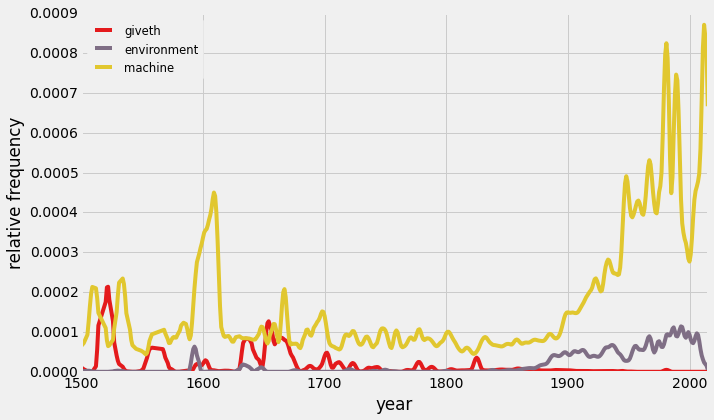

In [88]:
interact(plot_partial, words = 'giveth, environment, machine');

If you are very motivated, you can adapt the workflow above to work with higher-order n-grams and allow for the lookup of phrases (i.e. "world war") instead of just single words. To do this, you have to create a new `word_lookup` table and regenerate the vectors. Since single words (i.e. one-grams) will dominate, it might make sense to build separate list of top N-grams (top two-grams, top three-grams) and then merge them together into a vocabulary map. Beware that the size of the data will increase quickly for N > 1!

In [89]:
sc.stop()

To continue the exploration of the Gutenberg books corpus, you can move on to the [language classification notebook](part3-lang-classification-SOLUTIONS.ipynb).

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import subprocess

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from IPython.display import HTML
import xml.etree.ElementTree as ET
try:
    tree = ET.parse(os.environ['HADOOP_CONF_DIR'] + '/yarn-site.xml')
except IOError:
    raise IOError("Can't find the yarn configuration -- is HADOOP_CONF_DIR set?")
root = tree.getroot()
yarn_web_app = root.findall("./property[name='yarn.resourcemanager.webapp.address']")[0].find('value').text
yarn_web_app_string = "If this works successfully, you can check the <a target='_blank' href='http://{yarn_web_app}'>YARN application scheduler</a> and you should see your app listed there. Clicking on the 'Application Master' link will bring up the familiar Spark Web UI. "

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

<div class="alert alert-danger">
<h1>Create a Language Classifier</h1>
</div>

<div class="alert alert-success">
<b>The learning goals of this chapter are</b>
<ul>
<li> Learn about reduce, shuffles, partitioning and implications on network load </li>
<li> Reduce network load with mapPartition </li>
<li> Learn word vectorization methods using n-grams </li>
<li> Learn to use treeAggregate </li>
</ul>
</div>

# Analyzing the Gutenberg Books Corpus

In this notebook, we will use the cleaned, pre-processed data that we created in the [pre-processing part](gutenberg-preprocessing-SOLUTIONS.ipynb). As a reminder, we ended up with an RDD of `(gid, text)` tuples that has been cleaned and we stored it on HDFS at `/user/<YOUR_USERNAME>/gutenberg/cleaned_rdd`. 

In the [first analysis notebook](gutenberg-analysis-SOLUTIONS.ipynb) we build an N-gram viewer for the gutenberg books project. Now, we will use the corpus to train a simple language classification model using [Spark's machine learning library](http://spark.apache.org/docs/latest/mllib-guide.html).

## Set up and launch the Spark runtime

Remember from the previous notebook that we have a saved configuration in `./spark_config/` -- so all we need to do is set the `SPARK_CONF_DIR` environment variable and our default configuration will be used: 

In [2]:
# specify the configuration directory
os.environ['SPARK_CONF_DIR'] = os.path.realpath('./spark_config')

# how many cores do we have for the driver
ncores = int(os.environ.get('LSB_DJOB_NUMPROC', 1)) 

# here we set the memory we want spark to use for the driver JVM
os.environ['SPARK_DRIVER_MEMORY'] = '%dG'%(ncores*2*0.7)

# we have to tell spark which python executable we are using
os.environ['PYSPARK_PYTHON'] = subprocess.check_output('which python', shell=True).rstrip()

import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

In [3]:
conf = SparkConf()

sc = SparkContext(master='yarn-client', conf=conf)

## Load the data from HDFS

In [4]:
# TODO: load cleaned_rdd from the HDFS
cleaned_rdd = sc.pickleFile('/user/roskarr/gutenberg/cleaned_rdd').setName('cleaned_rdd').cache()

### A brief aside - correcting for data skew

Before we begin the loop-heavy analysis, we can do one more bit of optimization. Not all of the books in the corpus are the same length. This means that when we extract the ngrams, the differences will become even more pronounced. Since our basic unit of work here is a full book, this will result in uneven task execution times. Furthermore, because an individual "task" will actually process many books, this means that shorter books will be stuck in the queue behind longer books. 

To visualize this, lets count the number of characters in each partition: 

In [5]:
def count_chars_in_partition(iterator): 
    """
    Sum up the string lengths in each partition
    """
    c = 0
    for (gid, text) in iterator: 
        c+=len(text)
    yield c    

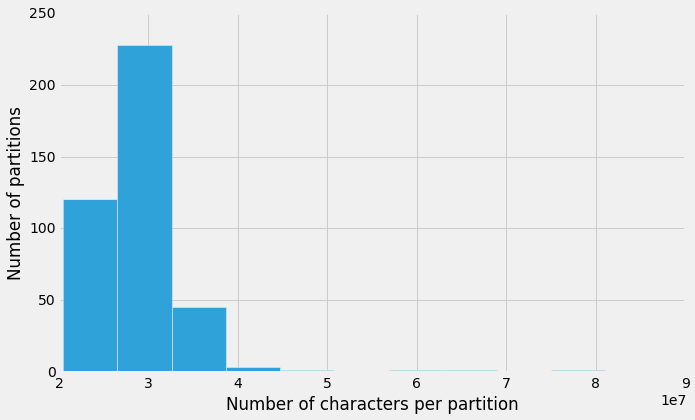

In [6]:
plt.hist(cleaned_rdd.mapPartitions(count_chars_in_partition).collect())
plt.xlabel('Number of characters per partition')
plt.ylabel('Number of partitions')

It's easy to see that some of the partitions have much more data than others. You can also verify this by looking at the Spark web UI for your job and clicking on the last stage that just executed (it will be named "collect"). You should see something like this at the top of the page: 

![Task summary](../../slides/figs/summary_tasks.png)
    
You can see that the longest tasks are taking several times more to execute than the mean even for this extremely simple operation. The data skew is clear if you scroll down a bit more and see the actual data input into each task and sort by duration: 

![Task duration](../../slides/figs/task_duration.png)

The longest few tasks are processing considerably more data than even the next several. Such a data skew may not matter for certain applications, but in our case we can expect it to make a difference. 

To try and correct it, we must first realize that for our application we have very few requirements about text order. We don't care about the order of words, as long as the documents are tagged with the correct language. So splitting a book into two and processing them out of order doesn't really matter. 

With this in mind, we can use a function like `chunk_text` below that creates approximately equal-sized "blocks" of text. The blocking means we'll get some spurious character ngrams at the beginning and end of each document, but if we block the data in large enough chunks this shouldn't matter too much.

In [7]:
def chunk_text(text, block_len=10000) : 
    """
    Ensure that blocks of text are no larger than `block_len`.
    
    Arguments: 
        
        text: the raw text string
    """
    len_text = len(text)
    
    if len_text < block_len : 
        return text
    else : 
        nblocks = len_text/block_len
        return [text[i*block_len:(i+1)*block_len] for i in xrange(nblocks)]

Now we apply this function to the `cleaned_rdd` and visualize the partition size distribution again. Since we want to keep the keys untouched, we can use the `flatMapValues` RDD method. However, since this method keeps the same data within each partition, we also need to *repartition* the data afterwards to randomize the chunk distributions. 

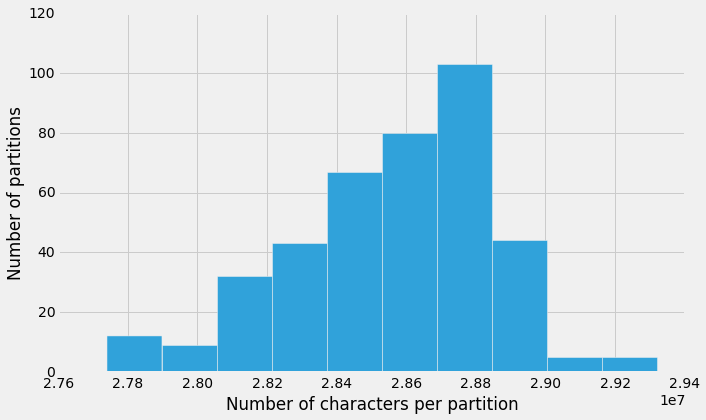

In [8]:
plt.hist(cleaned_rdd.flatMapValues(chunk_text)
                    .repartition(400)
                    .mapPartitions(count_chars_in_partition)
                    .collect())
plt.xlabel('Number of characters per partition')
plt.ylabel('Number of partitions')

The distribution is now still not perfect, but we have corrected it considerably. Lets make a restructured version of the full dataset and cache it: 

In [9]:
equalized_rdd = (cleaned_rdd.flatMapValues(chunk_text)
                            .setName('equalized_rdd')
                            .repartition(400)).cache()

### Load in the metadata dictionary and broadcast it

Just as in the previous notebook, we will load our pre-generated metadata dictionary and broadcast it to all the executors. 

In [10]:
from cPickle import load

with open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'r') as f :
    meta_dict = load(f)

In [11]:
# TODO: create meta_b by broadcasting meta_dict
meta_b = sc.broadcast(meta_dict)

Now, our `cleaned_rdd` contains `gid`'s as keys and text as values and if we want some other piece of metadata, we can just access it via the lookup table, for example `meta_b.value[gid][meta_name]`. 

We will use the same `extract_ngrams` and `vectorize_doc` functions as in the previous notebook: 

In [38]:
from pyspark.mllib.linalg import SparseVector

def extract_ngrams(tokens, ngram_range=[1,1], select_ngrams = None, ngram_type='word'):
    """
    Turn tokens into a sequence of n-grams 

    **Inputs**:

    *tokens*: a list of tokens

    **Optional Keywords**:

    *ngram_range*: a tuple with min, max ngram ngram_range
    
    *select_ngrams*: the vocabulary to use
    
    *ngram_type*: whether to produce word or character ngrams

    **Output**

    Generator yielding a list of ngrams in the desired range
    generated from the input list of tokens

    """
    join_str = "" if ngram_type=='character' else " "
    
    # handle token n-grams
    min_n, max_n = ngram_range
    n_tokens = len(tokens)
    
    for n in xrange(min_n, min(max_n + 1, n_tokens + 1)):
        for i in xrange(n_tokens - n + 1):
            if n == 1: 
                res = tokens[i]
            else : 
                res = join_str.join(tokens[i: i+n])
           
            # if we are using a lookup vocabulary, check for membership here
            if select_ngrams is not None : 
                if res in select_ngrams: 
                    yield res
            else : 
                yield res
            
def vectorize_doc(doc, vocab, ngram_range = [1,1], ngram_type='word') : 
    """
    Returns a vector representation of `doc` given the reference 
    vocabulary `vocab` after tokenizing it with `tokenizer`
    
    Arguments: 
        
        doc: a sequence of tokens (words or characters)
        
        vocab: the vocabulary mapping
        
    Keywords:
    
        ngram_range: the range of ngrams to process
        
        ngram_type: whether to produce character or word ngrams; default is 
        
    Returns:
    
        a sparse vector representation of the document given the vocabulary mapping
    """
    from collections import defaultdict
    from scipy.sparse import csr_matrix 
        
    # count all the word occurences 
    data = np.zeros(len(vocab))
    
    for ngram in extract_ngrams(doc, ngram_range, vocab, ngram_type) : 
         data[vocab[ngram]] += 1
            
    # only keep the nonzero indices for the sparse representation
    #indices = data.nonzero()[0]
    #values = data[indices]
    
    #return SparseVector(len(vocab), indices, values)
    return data

# Language classification

Here we will try to use some of the same techniques we developed before, but apply them to a classification problem: determining whether a text is English or German. 

We will use the rather straightforward method outlined in [Cavnar & Trenkle 1994](http://odur.let.rug.nl/~vannoord/TextCat/textcat.pdf):

For each of the English/German training sets:

1. tokenize the text (spaces are also tokens, so we replace them with "_")
2. extract N-grams where 1 < N < 5
3. determine the most common N-grams for each corpus
4. encode both sets of documents using the combined top ngrams



In the last notebook, we used words as "tokens" -- now we will use characters, even accounting for white space (which we will replace with "_"). We will use the two example sentences again:

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
First, we use the `extract_ngrams` function: 

In [39]:
s1 = "a dog bit me"
s2 = "i bit the dog back"

In [40]:
ngrams1 = list(extract_ngrams(s1.replace(' ','_'), ngram_range=[1,5], ngram_type='character'))
ngrams2 = list(extract_ngrams(s2.replace(' ','_'), ngram_range=[1,5], ngram_type='character'))

In [41]:
print(list(ngrams1))

['a', '_', 'd', 'o', 'g', '_', 'b', 'i', 't', '_', 'm', 'e', 'a_', '_d', 'do', 'og', 'g_', '_b', 'bi', 'it', 't_', '_m', 'me', 'a_d', '_do', 'dog', 'og_', 'g_b', '_bi', 'bit', 'it_', 't_m', '_me', 'a_do', '_dog', 'dog_', 'og_b', 'g_bi', '_bit', 'bit_', 'it_m', 't_me', 'a_dog', '_dog_', 'dog_b', 'og_bi', 'g_bit', '_bit_', 'bit_m', 'it_me']


We can create the vocabulary by getting the set of all ngrams and building a lookup table:

In [42]:
vocab = set(ngrams1) | set(ngrams2)

In [43]:
vocab_dict = {word:ind for ind,word in enumerate(vocab)}
print('number of ngrams: ',len(vocab_dict))

number of ngrams:  89


Note that extracting ngrams can increase the size of the data quite a lot!

In [44]:
vocab_dict

{'_': 73,
 '_b': 24,
 '_ba': 12,
 '_bac': 19,
 '_back': 27,
 '_bi': 8,
 '_bit': 29,
 '_bit_': 54,
 '_d': 23,
 '_do': 55,
 '_dog': 83,
 '_dog_': 72,
 '_m': 18,
 '_me': 84,
 '_t': 15,
 '_th': 71,
 '_the': 36,
 '_the_': 31,
 'a': 74,
 'a_': 66,
 'a_d': 34,
 'a_do': 58,
 'a_dog': 88,
 'ac': 5,
 'ack': 62,
 'b': 41,
 'ba': 68,
 'bac': 67,
 'back': 25,
 'bi': 70,
 'bit': 37,
 'bit_': 6,
 'bit_m': 35,
 'bit_t': 30,
 'c': 75,
 'ck': 0,
 'd': 42,
 'do': 26,
 'dog': 81,
 'dog_': 7,
 'dog_b': 9,
 'e': 76,
 'e_': 64,
 'e_d': 49,
 'e_do': 21,
 'e_dog': 51,
 'g': 77,
 'g_': 14,
 'g_b': 59,
 'g_ba': 63,
 'g_bac': 22,
 'g_bi': 65,
 'g_bit': 3,
 'h': 44,
 'he': 38,
 'he_': 4,
 'he_d': 50,
 'he_do': 11,
 'i': 78,
 'i_': 60,
 'i_b': 57,
 'i_bi': 28,
 'i_bit': 85,
 'it': 56,
 'it_': 17,
 'it_m': 53,
 'it_me': 33,
 'it_t': 43,
 'it_th': 69,
 'k': 79,
 'm': 80,
 'me': 39,
 'o': 82,
 'og': 47,
 'og_': 40,
 'og_b': 2,
 'og_ba': 13,
 'og_bi': 16,
 't': 48,
 't_': 1,
 't_m': 61,
 't_me': 32,
 't_t': 87,
 't_th'

And finally, we can use `vectorize_doc` with the vocabulary mapping to turn the documents into vectors: 

In [45]:
vectorize_doc(s1.replace(' ','_'), vocab_dict, ngram_range=[1,5], ngram_type='character')

array([ 0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.])

### Saving memory consumption with `mapPartitions`

As you could see from the simple example of extracting ngrams from two short phrases above, by extracting the 1-5 grams from a simple 12-character string, we created a vector with 48 stored values. Our actual documents will therefore swell in size very rapidly -- we definitely don't want to be holding all of those huge lists in memory! 

Remember, our first goal is to get the top most-used N-grams. For this, we just need to create an RDD of N-grams and to avoid building lists we'll use the technique of generators discussed on the first day. 

Note that the `extract_ngrams` function above is already a generator: now we just want to make a small wrapper function that uses `extract_ngrams` to "yield" ngrams one by one into the RDD. 

A slight complication is that `mapPartitions` gives us a partition *iterator* over the data in the partition. This iterator will give us partition data one element at a time, which in this case are just the individual documents. We can pass each of these documents to `extract_ngrams`. 

In [46]:
from collections import defaultdict

def ngram_generator(iterator, ngram_range=[1,1], ngram_type='word') : 
    """Take an iterator of documents and create a generator of ngrams
    
    Arguments:
        
        iterator: the document iterator
        
    Keywords:
        
        ngram_range: the range of ngrams to consider
        
        ngram_type: whether to extract word or character ngrams; default is word
    """ 
    for text in iterator : 
        for ngram in extract_ngrams(text.replace(' ', '_'), ngram_range, ngram_type=ngram_type): 
            yield ngram

We will subsample the english part of `equalized_rdd` in order to make this next set of cells complete in a reasonable amount of time -- once it's working, you can go back and do it for the full dataset, but it will take approximately 30 minutes. 

In [47]:
# TODO: create english_rdd and german_rdd by filtering the sampled_rdd for 'en' and 'de' 
# Use only a 10% sample of the english documents to make the ngram extraction 
# complete in a reasonable amount of time

english_rdd = (equalized_rdd.filter(lambda (gid, text): (meta_b.value[gid]['lang'] == 'en'))
                            .sample(False, 0.1)
                            .setName('english_rdd')).cache()

german_rdd  = (equalized_rdd.filter(lambda (gid, text): (meta_b.value[gid]['lang'] == 'de'))
                            .setName('german_rdd')).cache()

ngram_range = [1,3] # should use 1-5 ngram range, but make it smaller to speed up the processing a bit

#### Making the sets of most common english and german ngrams

To build the sets of ngrams, we use the now-familiar pattern: 

1. map the documents in the RDDs to their constituent ngrams (here we use the mapPartition call with the `ngram_generator` defined above)
2. do the distributed key count using the `map` --> `(key, 1)` --> `reduceByKey` pattern
3. sort the result (in descending order) and take the top 1000 ngrams

In [23]:
# TODO: 
en_ngram_counts = (english_rdd.values()
                               .mapPartitions(lambda it: ngram_generator(it, ngram_range, ngram_type='character'))
                               .map(lambda ngram: (ngram,1))
                               .reduceByKey(lambda a,b:a+b).cache())

In [24]:
# TODO
de_ngram_counts = (german_rdd.values()
                               .mapPartitions(lambda it: ngram_generator(it, ngram_range, ngram_type='character'))
                               .map(lambda ngram: (ngram,1))
                               .reduceByKey(lambda a,b:a+b).cache())

In [25]:
%%time
top_1000_en_ngrams = (en_ngram_counts.sortBy(lambda (ngram,count): count, False)
                                     .map(lambda (ngram, count): ngram)
                                     .take(1000))

CPU times: user 423 ms, sys: 115 ms, total: 538 ms
Wall time: 2min 52s


In [26]:
%%time
top_1000_de_ngrams = (de_ngram_counts.sortBy(lambda (ngram,count): count, False)
                                     .map(lambda (ngram, count): ngram)
                                     .take(1000))

CPU times: user 332 ms, sys: 93 ms, total: 425 ms
Wall time: 53.2 s


In [27]:
# building the top_ngrams dictionaries
# combine the german and english ngrams
top_ngrams = set(top_1000_de_ngrams) | set(top_1000_en_ngrams)

# build the ngrams dictionary lookup
top_ngrams_dict = {ngram:i for (i,ngram) in enumerate(top_ngrams)}

# broadcast the ngrams dictionary
top_ngrams_dict_b = sc.broadcast(top_ngrams_dict)

### Vectorizing the documents based on top 1000 ngrams from each language

For our logistic regression application, we are going to want to balance out the number of documents from the two languages. We know that English is by far over-represented, so we'll create a list of english and german document ID's that will balance out the two samples. 

In [28]:
german_ids = cleaned_rdd.map(lambda (gid, _): gid).filter(lambda gid: meta_b.value[gid]['lang'] == 'de').collect()
english_ids = cleaned_rdd.map(lambda (gid, _): gid).filter(lambda gid: meta_b.value[gid]['lang'] == 'en').collect()

combined_ids = set(german_ids + english_ids[:len(german_ids)])

In [29]:
# create an RDD of german and english
en_de_rdd = equalized_rdd.filter(lambda (gid, text): gid in combined_ids)

Now we can vectorize the documents just like we did in the previous notebook by using `vectorize_doc` with the broadcast vocabulary lookup we made above (`top_ngrams_dict_b` - remember to pass in its `value`!) and the pre-defined `ngram_range`. Be sure to change all spaces to '_' before passing in to `vectorize_doc` and to specify `ngram_type`. 

In [48]:
vector_rdd = (en_de_rdd.map(lambda (gid,text): (gid, 
                                                 vectorize_doc(text.replace(' ','_'),top_ngrams_dict_b.value, ngram_range, ngram_type='character')))
                           .cache())

In [49]:
vector_rdd.first()

(13208, array([ 179.,   11.,    0., ...,    0.,    8.,  353.]))

Since we split the documents to equalize the vectorization load, we must now add the vectors for a given document back together: 

In [31]:
def add_sparse(v1, v2) :
    temp_vec = np.zeros(v1.size, dtype = np.float32)
    for v in [v1,v2]: 
        temp_vec[v.indices] += v.values
    nonzero = temp_vec.nonzero()[0]
    
    return SparseVector(v1.size, nonzero, temp_vec[nonzero])

In [51]:
combined_rdd = vector_rdd.reduceByKey(lambda x,y: x+y)

## Train the language classification model

To train the model, we need to first map the `vector_rdd` elements into [`LabeledPoint`](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=labeledpoint#pyspark.mllib.regression.LabeledPoint), which is just a Spark abstraction that encompases a *label* and a *vector*. We then split the data into a training and validation sets and produce the trained model. 

In [53]:
from pyspark.mllib.feature import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD

In [64]:
# making a simple LabeledPoint with label '0' and vector [1,2,3,4]
LabeledPoint(0, [1,2,3,4])

LabeledPoint(0.0, [1.0,2.0,3.0,4.0])

First, create a `vector_lp` RDD by mapping the contents of `vector_rdd` into a `LabeledPoint` using 0 if the language is English and 1 if it is German with the provided `gid_to_label` function:

In [54]:
# TODO: create an RDD of LabeledPoint with 0 for english and 1 for german
def gid_to_label(gid):
    """Simple helper function that converts gid to 0 for english or 1 for german"""
    lang = meta_b.value[gid]['lang']
    if lang == 'en':
        return 0
    elif lang == 'de':
        return 1
    else:
        raise RuntimeError("Can't handle language '{lang}'".format(lang=lang))
    
vector_lp = combined_rdd.map(lambda (gid, vec): LabeledPoint(gid_to_label(gid), vec))

The Spark machine learning library provides a simple method for creating training and validation sets, which we will use below. These will be our inputs for the logistic regression model fitting -- it is *always* a good idea to cache the inputs, since the training requires many iterations over the data. 

In [56]:
training, validation = vector_lp.randomSplit([0.7,0.3], seed=10)
print(training.cache().count())
print(validation.cache().count())

1327
541


#### Pass the training set to the model

Here we will use the basic logistic regression model with stochastic gradient descent -- feel free to experiment with different parameters and other models from [pyspark.mllib.classification](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#module-pyspark.mllib.classification).

In [57]:
model = LogisticRegressionWithSGD.train(training, regType='l1', regParam=.1)

To check the performance of the model, we define a function that takes a data RDD and a model as parameters and computes the error:

In [58]:
def check_model(data, model) : 
    """Calculates the model error on the data
    
    Arguments: 
        
        data: the data RDD
        
        model: the classification model
        
    Returns:
    
        the error, which is the fraction of incorrectly predicted elements
    """
    
    error = (data.map(lambda p: (p.label, model.predict(p.features)))
                 .filter(lambda (v,p): v!=p).count())/float(data.count())
    return error

In [59]:
train_error = check_model(training, model)
print("Training Error = " + str(train_error))
validation_error = check_model(validation, model)
print("Validation Error = " + str(validation_error))

Training Error = 0.0135644310475
Validation Error = 0.0147874306839


For fun, lets create a function that will score a new string of text: 

In [60]:
def predict_language(text, model) : 
    """Predict the language given the pre-trained model
    
    Arguments: 
        text: a string
        
        model: the trained logistic regression model
    """
    vec = vectorize_doc(text.replace(' ','_'), top_ngrams_dict_b.value, [1,2])
    
    res = 'german' if model.predict(vec) == 1 else 'english'
    print(text + ' is ' + res)

predict_lang_partial = lambda text: predict_language(text, model)

Try it out! Enter your own sentence:

In [61]:
interact(predict_lang_partial, text='a dog bit me');

a dog bit me is english


### Which character sequences define each language? 

Here we'll use the weights of the trained model to identify the words with the lowest weights (i.e. those that pull a prediction toward zero) and the highest weights (those that pull a prediction toward 1). 

In [63]:
sorted_weights = np.argsort(model.weights)

top_ngram_inds = {v:k for k,v in top_ngrams_dict.iteritems()}

print('top 50 english and german ngrams and their weights:')
for i in range(50): 
    eng_ind = sorted_weights[i]
    ger_ind = sorted_weights[len(top_ngram_inds)-i-1]
    print('%s\t%d\t%s\t%d'%(top_ngram_inds[eng_ind], model.weights[eng_ind], 
                            top_ngram_inds[ger_ind], model.weights[ger_ind]))

top 50 english and german ngrams and their weights:
o	-8841	e	9530
t	-5978	n	6590
_t	-5874	en	5341
th	-5444	n_	4951
_	-4593	en_	4534
_th	-4532	ch	4531
the	-3670	_d	3847
a	-3542	u	3608
he	-3356	er	3520
y	-3193	ei	3283
he_	-2979	de	2896
d_	-2855	ie	2607
_o	-2418	ge	2406
y_	-2372	r_	2325
e_	-2352	i	2297
_a	-2217	g	2284
s_	-1990	r	2244
p	-1932	er_	2139
h	-1774	z	2135
ed_	-1617	te	1900
ou	-1515	ich	1897
_of	-1470	un	1887
to	-1446	_e	1885
of	-1445	d	1843
of_	-1434	_de	1795
_c	-1383	ein	1783
ed	-1357	ie_	1724
f	-1348	ic	1574
o_	-1326	ch_	1510
at	-1269	au	1484
_to	-1249	_u	1467
_an	-1208	sch	1433
an	-1204	c	1425
_h	-1202	der	1370
on	-1193	_un	1368
and	-1193	sc	1309
to_	-1188	die	1231
f_	-1154	n_d	1218
ea	-1049	und	1138
hi	-1042	m	1137
ing	-883	be	1101
_p	-868	_di	1087
or	-867	cht	1059
re	-865	_z	1046
d_t	-853	_g	1046
is_	-842	di	1031
_a_	-830	_ei	1008
at_	-828	h_	993
co	-812	k	993
w	-791	te_	986


Some other ideas for things you could do with this dataset: 

* try other [classifiers that are included in MLlib](http://spark.apache.org/docs/latest/mllib-classification-regression.html)
* build a regression model to predict year of publication
* run a clustering algorithm on the full language data
* do clustering on the english books and see if sub-groups of the language pop up
* cluster by author -- do certain authors write in similar ways?

<div class="alert alert-danger">
<h1>Create Language Classifier using Spark Pipelines</h1>
</div>

<div class="alert alert-success">
<b>The learning goals of this chapter are</b>
<ul>
<li> Learn Spark Pipeline Concepts </li>
</ul>
</div>

